# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 23 Νοεμβρίου 2021


In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [ ]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [ ]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
# team 38
team_seed_number = 38

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe corpus_df που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [ ]:
import pprint
# print summary as a paragraph in order to view without scrolling to the right
def prettyprint(mystring):
  s_pp = pprint.pformat(mystring, width=150, compact=True)
  s_pp = s_pp.replace("'","")
  s_pp = s_pp.replace('"','')
  s_pp = "\n" + " " + s_pp[1:len(s_pp)-1]
  return s_pp

ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(prettyprint(corpus[ID]))
print(type(corpus))

['Detention: The Siege at Johnson High']
['"Thriller",  "Drama"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
# call Vectorizer with default parameters
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf_plain = vectorizer.transform(corpus).toarray()

In [ ]:
print(f'Our TF-IDF array shape is : {corpus_tf_idf_plain.shape}')
print(f'That means our vectorizer vocabulary contains {len(vectorizer.get_feature_names_out())} words')
# print(len(vectorizer.get_stop_words()))

Our TF-IDF array shape is : (5000, 48758)
That means our vectorizer vocabulary contains 48758 words


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [ ]:
import scipy as sp

def content_recommender(target_movie, max_recommendations, corpus_type):
  print(f'Our Target Movie ID is: {target_movie}')
  print(f'Our Target Movie Title is {titles[target_movie]}')
  print(f'Our Target Movie Summary is: \n {prettyprint(corpus[target_movie])}')
  print(f'Our Target Movie Categories are: \n {categories[target_movie]}')

  # initialize dataframe parameteres
  index_df = []
  recommendation_level_df = []
  recommendation_id_df = []
  recommendation_title_df = []
  recommendation_cosine_similarity_df = []
  recommendation_categories_df = []

  # cosine similarity between our target-movie and the rest movies of our dataset
  cosine_similarity = {}
  for i in range(len(corpus_type)):
    cosine_similarity[f'Target Movie Similarity With Movie {i}'] = [1.0 - sp.spatial.distance.cosine(corpus_type[target_movie], corpus_type[i]), i]
  # sort dictionary by the cosine similarity
  cosine_similarity_sorted = dict(sorted(cosine_similarity.items(), key=lambda x: x[1][0], reverse=True))
  recommendation_counter = 1
  for key, value in cosine_similarity_sorted.items():
    if recommendation_counter > max_recommendations:
      print("\n \n \n")
      break
    elif value[1] == target_movie:
      # don't show our Target_Movie info again but show them in the DataFrame returned for visual purposes
      index_df.append(titles[target_movie][0])
      recommendation_level_df.append("Original Movie")
      recommendation_id_df.append(value[1])
      recommendation_title_df.append(titles[value[1]][0])
      recommendation_cosine_similarity_df.append(value[0])
      recommendation_categories_df.append(categories[value[1]])
      index_df.append("--------------------")
      recommendation_level_df.append("--------------------")
      recommendation_id_df.append("--------------------")
      recommendation_title_df.append("--------------------")
      recommendation_cosine_similarity_df.append("--------------------")
      recommendation_categories_df.append("--------------------")
    else:
      index_df.append(titles[target_movie][0])
      recommendation_level_df.append(recommendation_counter)
      recommendation_id_df.append(value[1])
      recommendation_title_df.append(titles[value[1]][0])
      recommendation_cosine_similarity_df.append(value[0])
      recommendation_categories_df.append(categories[value[1]])
      print(f' \n  \n \t \t Recommendation No.{recommendation_counter} \n')
      print(f'No.{recommendation_counter} Recommended Movie ID is: {value[1]}')
      print(f'No.{recommendation_counter} Recommended Movie Title is {titles[value[1]]}')
      print(f'{titles[value[1]]} Cosine Similarity with {titles[target_movie]} is : {value[0]}')
      print(f'No.{recommendation_counter} Recommended Movie Summary is: \n {prettyprint(corpus[value[1]])} \n')
      print(f'No.{recommendation_counter} Recommended Movie Categories are: \n {categories[value[1]]}')
      recommendation_counter += 1

  data = {'Recommendation No': recommendation_level_df, 'Recommended Movie ID':recommendation_id_df,
          'Recommended Movie Title':recommendation_title_df, 'Cosine Similarity':recommendation_cosine_similarity_df,
          'Recommended Movie Categories': recommendation_categories_df}
  df = pd.DataFrame(data, index_df)
  # we return a dataframe also for visual purposes
  return df.style.set_caption(f'Recommended Movies Based On: {titles[target_movie][0]}').set_table_styles(
      [{'selector': 'th', 'props': [('text-align', 'left')]}, 
       {'selector': 'caption', 'props': [('color', '#f00e0e '), ('font-size', '22px'), ('font-weight', 'bold'), ('text-align', 'center')]},
       {'selector': 'th.col_heading', 'props': [('color', '#ffffff '), ('font-size', '20px'), ('font-weight', 'bold'), ('text-align', 'center')]}])


In [ ]:
#run 1 Test of our content_recommender
content_recommender(1, 5, corpus_tf_idf_plain)

Our Target Movie ID is: 1
Our Target Movie Title is ["Scooby-Doo and the Witch's Ghost"]
Our Target Movie Summary is: 
 
 Ben Ravencroft, a famous horror writer who Velma is a big fan of, assists the Mystery, Inc. gang in solving a case at a museum. Ben invites them 
 to his hometown, Oakhaven in New England. When they arrive, they find the town converted into a tourist attraction by Mayor Corey, complete with 
 17th-century replicas and attractions based on the alleged ghost of Sarah Ravencroft, an ancestor of Bens who was persecuted as a witch by the 
 town in 1657. Ben disputes this, claiming Sarah to be a Wiccan who used natural herbs to heal people and had a diary that could prove her 
 innocence. Scooby and Shaggy are chased by a witch and run into Ben and the gang. They find broken tree branches at the scene and are drawn to an 
 all-female goth rock band, Hex Girls, lead by Sally Thorn McKnight. The gang then decides to split up; Fred and Daphne stay to watch the Hex 
 Girls, V

#### Παρατηρούμε πως με καμία βελτιστοποίηση βρέθηκαν περίπου 3 παρόμοιες ταινίες με ομοιότητα συνημιτόνου να αρχίζει από 0.41. Να τονίσουμε πως με την παρούσα υλοποίηση με 1 έχουμε την ίδια την ταινία με τον εαυτό της ενώ όσο πλησιάζουμε στο 0 οι ταινίες που προτείνονται δεν είναι τόσο όμοιες. Χαρακτηριστικό αποτελεί πως η 1η προτεινόμενη ταινία και η 3η είναι ταινίες της σειράς Scooby Doo.

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




### Aρχικά χωρίζουμε όλες τις λέξεις σε κάθε corpus.

In [ ]:
import nltk
nltk.download('punkt') # χρειάζεται για το tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
words = []

for summary in corpus:
  words += nltk.word_tokenize(summary)
before_preprocessing_words = len(words)
print(f'Total words in whole corpus are: {before_preprocessing_words}')

Total words in whole corpus are: 1774948


### Ύστερα ορίζουμε όλα τα stopwords που θα αφαιρέσουμε. Κάποια stopwords προέρχονται από παρατήρηση των corpus κάθε ταινίας.

In [ ]:
import spacy
import string

#loading the english language small model of spacy
# also spacy has more stopwords than nltk
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
# add 4 extra stopwords
sw_spacy.add("movie")
sw_spacy.add("film")
sw_spacy.add("cinema")
sw_spacy.add("plot")
sw_spacy.add("movies")
sw_spacy.add("films")
sw_spacy.add("cinemas")
sw_spacy.add("plots")
print(f"We currently have {len(sw_spacy)} stopwords")

We currently have 334 stopwords


In [ ]:
nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [ ]:
import collections
nltk.download('omw-1.4')

def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words

def preprocess_document(document):
    # lowercase
    words = nltk.word_tokenize(document.lower())
    # remove stopwords
    filtered_words = [word for word in words if word not in list(sw_spacy) + list(string.punctuation)]
    # remove extra punctuations
    filtered_words = thorough_filter(filtered_words)
    # lemmatization
    lem_words = [wordnet_lemmatizer.lemmatize(word) for word in filtered_words]
    #stemming
    #stem_words = [porter_stemmer.stem(word) for word in filtered_words]
    return " ".join(lem_words)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [ ]:
preprocessed_corpus = [preprocess_document(summary) for summary in corpus]

In [ ]:
preprocessed_words =[]
for movie in preprocessed_corpus:
    preprocessed_words += nltk.word_tokenize(movie)

after_preprocessing_words = len(preprocessed_words)

In [ ]:
print(f'Total words in whole corpus before preprocessing are: {before_preprocessing_words}')
print(f'Total words in whole corpus after preprocessing are: {after_preprocessing_words}')

Total words in whole corpus before preprocessing are: 1774948
Total words in whole corpus after preprocessing are: 784036


### Αφού πραγματοποιήσαμε την παραπάνω προεπεξεργασία προχωράμε στη βελτιστοποίηση των παραμέτρων της TfidfVectorizer.

#### Σε αυτό το σημείο έχουμε ήδη κόψει σχεδόν τις μισές λέξεις από όλα τα corpus. Ωστόσο χωρίς περαιτέρω βελτιστοποίηση του Vectorizer το vocabulary μας δε πέφτει κάτω από 35.000. Συνέπως συνεχίζουμε με τη βελτιστοποίηση των max_df και min_df. Για max_df θέτουμε το 0.5 δηλαδή να κόβει λέξεις που εμφανίζονται στα μισά κείμενα. Για min_df θέτουμε το 14 δηλαδή λέξεις που εμφανίζονται λιγότερο από 14 φορές σε όλα τα κείμενα. Με αυτό τον τρόπο πέφτουμε κοντά στις 5800 λέξεις. Ουσιαστικά δοκιμάσαμε διάφορες τιμές για το min_df ανάμεσα στο 10 και στο 15. Σκοπός μας ήταν έχουμε ένα διάνυσμα μήκους κοντά στις 5.000 και ταυτόχρονα να έχουμε όσο το δυνατόν γίνεται ικανοποιητικά αποτελέσματα. Τέλος με την παράμετρο stop_words='english' ουσιαστικά κόβουμε περίπου άλλες 150 λέξεις παραπάνω καθώς έχουμε ήδη κόψει πολλές από την προεπεξεργασία. 


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer1 = TfidfVectorizer(max_df=0.5, min_df=14, stop_words='english')
vectorizer1.fit(preprocessed_corpus)
corpus_tf_idf = vectorizer1.transform(preprocessed_corpus).toarray()
print(f'Our TF-IDF array shape is : {corpus_tf_idf.shape}')
print(f'That means our vectorizer vocabulary after preprocessing contains {len(vectorizer1.get_feature_names_out())} words')

Our TF-IDF array shape is : (5000, 5797)
That means our vectorizer vocabulary after preprocessing contains 5797 words


#### Θυμόμαστε πριν την προεπεξεργασία για την ταινία Scooby-Doo and the Witch's Ghost με ΙD=1 μας είχε βγεί ως πρώτη προτεινόμενη η ταινία Scooby-Doo! Curse of the Lake Monster με ID=2646 και 3η προτεινόμενη η ταινία Scooby Doo in Where's My Mummy με ID=1467. Οπότε παρακάτω θέτουμε στη συνάρτηση content_recommender το ID:2646.

In [ ]:
content_recommender(2646, 8, corpus_tf_idf)

Our Target Movie ID is: 2646
Our Target Movie Title is ['Scooby-Doo! Curse of the Lake Monster']
Our Target Movie Summary is: 
 
  School has just ended. Velma  and Shaggy  are waiting by the van for Fred  and Daphne  so they can go to meet Daphnes Uncle, who has given them 
 summer jobs at his country club in Erie Point so the gang can pay for the damages they did to a barn setting it on fire during one of their 
 mysteries. They then find Fred and Daphne making out in the back of the van. Daphne reveals that they started dating after she fell out of the top 
 of the barn from the mystery that caused them to get the summer jobs and he had caught her, making her realize that he was the one. Velma warns 
 them that often when two people in a group start dating, any changes of that relationship affects the whole group, but the two dont seem to care. 
 On the way to the country club, Fred gets lost. They stop at a small country store called Trowburgs where a seemingly crazy woman tells th

#### Παρατηρούμε πως η ταινία με ID=2646 έχει πρώτη προτεινόμενη την ταινία με ID=1467 κάτι το οποίο το είχαμε εντοπίσει και στο μη επεξεργασμένο corpus. Παρατηρούμε επίσης πως το cosine similatity έχει μειωθεί στις 10 προτεινόμενες ταινίες κάτι το οποίο είναι λογικό καθώς από διάνυσμα μήκους  48.758 πέσαμε σε διάνυσμα 5797. 

#### Ωστόσο οι προτεινόμενες ταινίες έχουν πολλά κοινά χαρακτηριστικά με την ταινία Scooby-Doo! Curse of the Lake Monster. Μάλιστα οι πρώτες 3 προτεινόμενες ταινίες είναι παιδικές ταινίες και έχουν παρόμοια genre. Ακόμα και η 5η προτεινόμενη ταινία είναι Animation και Fantasy. Ωστόσο οι υπόλοιπες ταινίες δε κυμαίνονται σε παρόμοια θεματολογία.

#### Ας αλλάξουμε θεματολογία και ας ελέγξουμε τις προτεινόμενες ταινίες για την ταινία Harry Potter and the Goblet of Fire με ID=4026.

In [ ]:
content_recommender(4026, 8, corpus_tf_idf)

Our Target Movie ID is: 4026
Our Target Movie Title is ['Harry Potter and the Goblet of Fire']
Our Target Movie Summary is: 
 
  Now fourteen years old, Harry Potter dreams of an elderly man, Frank Bryce, who is killed after overhearing Lord Voldemort discussing plans with 
 Peter Wormtail Pettigrew and Barty Crouch Jr. The Quidditch World Cup allows Harry to take his mind off his nightmares until followers of 
 Voldemort known as Death Eaters terrorise the spectators campsites after the match, and Crouch Jr. summons the Dark Mark, a sign showing that 
 Voldemort is returning to power. At Hogwarts, headmaster Albus Dumbledore introduces ex-Auror Alastor Mad-Eye Moody as the new Defence Against 
 the Dark Arts teacher. In their first Defence Against the Dark Arts lesson, the students learn of the three Unforgivable Curses. The Imperius 
 Curse causes absence of free will, the Cruciatus Curse causes unbearable pain, and the final curse, Avada Kedavra, causes death. Dumbledore 
 announces

#### Παρατηρούμε πως η πρώτη προτεινόμενη ταινία είναι ο Harry Potter and the Prisoner of Azkaban με ID=1979  και βαθμός ομοιότητας 0.62. Ωστόσο οι υπόλοιπες ταινίες δυστυχώς αν και έχουν υψηλό βαθμό ομοιότητας δυστυχώς δεν είναι σε καμία περίπτωση όμοιες. Η ομοιότητα τους οφείλεται στο γεγονός πως ο πρωταγωνιστής της εκάστοτε ταινίας λέγεται Harry. Συνεπώς πρέπει να προσθέσουμε και τα ανδρικά και τα γυναικεία ονόματα στο set sw_spacy το οποίο είναι ένα σύνολο από τα stopwords. Αυτό το κάνουμε παρακάτω και ύστερα ξανατρέχουμε το παραπάνω test για να εκτιμήσουμε τις διαφορές αυτής την επιπλέον βελτιστοποίησης.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving stopwords.txt to stopwords.txt
User uploaded file "stopwords.txt" with length 44454 bytes


In [ ]:
!ls

sample_data  stopwords.txt


In [ ]:
with open('stopwords.txt', 'r') as f:
    document = ''
    for line in f:
        document += line

print(document)
print(len(document))
# harry name is inside the document ...

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, a, aaron, abbey, abbie, abdul, abe, across, abel, abigail, about, above, abraham, abram, abst, accordance, according, act, actually, ada, adah, adalberto, adaline, adam, adan, added, among, addie, adela, adelaida, adelaide, adele, adelia, adelina, adeline, adell, adella, adelle, adena, adina, adj, adolfo, adolph, adopted, adria, adrian, adriana, adriane, adrianna, adrien, adrienne, after, afterwards, afton, again, against, agatha, agnes, agnus, agueda, agustina, ahmad, ahmed, ai, aida, besides, aide, aiko, aileen, ailene, aimee, aja, akilah, al, alaina, alaine, alan, alana, alane, alanna, alayna, alba, albert, alberta, albertha, albertina, albertine, alberto, albina, alda, alden, aldo, alease, alec, alecia, e, aleen, aleisha, eg, alejandra, alejandrina, alejandro, alena, elsewhere, alene, alesha, aleshia, alesia, alessandra, aleta, aletha, everywhere, alethea, alethia, alex, alexander, alexandria, alexia, alexis, alfonso, alfonzo, alfred, alfreda, alfredia

In [ ]:
# save the stopwords in list_names, without spaces and commas from the original file
list_names = []
current = ""
for i in range(len(document)):
    if document[i] == ",":
      list_names.append(current)
      current = ""
      continue
    if document[i] == " ":
      current = ""
      continue
    else:
      current = current + document[i]

print(list_names)
print(len(list_names))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'aaron', 'abbey', 'abbie', 'abdul', 'abe', 'across', 'abel', 'abigail', 'about', 'above', 'abraham', 'abram', 'abst', 'accordance', 'according', 'act', 'actually', 'ada', 'adah', 'adalberto', 'adaline', 'adam', 'adan', 'added', 'among', 'addie', 'adela', 'adelaida', 'adelaide', 'adele', 'adelia', 'adelina', 'adeline', 'adell', 'adella', 'adelle', 'adena', 'adina', 'adj', 'adolfo', 'adolph', 'adopted', 'adria', 'adrian', 'adriana', 'adriane', 'adrianna', 'adrien', 'adrienne', 'after', 'afterwards', 'afton', 'again', 'against', 'agatha', 'agnes', 'agnus', 'agueda', 'agustina', 'ahmad', 'ahmed', 'ai', 'aida', 'besides', 'aide', 'aiko', 'aileen', 'ailene', 'aimee', 'aja', 'akilah', 'al', 'alaina', 'alaine', 'alan', 'alana', 'alane', 'alanna', 'alayna', 'alba', 'albert', 'alberta', 'albertha', 'albertina', 'albertine', 'alberto', 'albina', 'alda', 'alden', 'aldo', 'alease', 'alec', 'alecia', 'e', 'aleen', 'aleisha', 'eg', 'alejandra', 

In [ ]:
# add stopwords in our set of stopwords
for i in range(len(list_names)):
  sw_spacy.add(list_names[i])
# some values in list_names were already in sw_spacy, from 300+ stopwords now we have 5600+ stopwords
print(len(sw_spacy))

5688


In [ ]:
# inside function: preprocess_document 
# lies the new updated sw_spacy 
preprocessed_corpus_without_names = [preprocess_document(summary) for summary in corpus]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# run again the Vectorizer 
vectorizer_without_names = TfidfVectorizer(max_df=0.5, min_df=14, stop_words='english')
vectorizer_without_names.fit(preprocessed_corpus_without_names)
corpus_tf_idf_without_names = vectorizer_without_names.transform(preprocessed_corpus_without_names).toarray()
print(f'Our TF-IDF array shape is : {corpus_tf_idf_without_names.shape}')
print(f'That means our vectorizer vocabulary after adding extra stopwords contains {len(vectorizer_without_names.get_feature_names_out())} words for every movie')

Our TF-IDF array shape is : (5000, 5373)
That means our vectorizer vocabulary after adding extra stopwords contains 5373 words for every movie


#### Αυτή τη φορά έχουμε αφαιρέσει τα ονόματα, ανδρικά και γυναικεία καθώς και άλλα stopwords από την αγγλική γλώσσα. Κάποια stopwords τα πήραμε ήδη από spacy και συμπληρώσαμε από το δικό μας αρχείο stopwords.txt καθώς και από την παράμετρο stopwords του TfidfVectorizer.

#### Από διάνυσμα μήκους 5797 έχουμε πλέον διάνυσμα μήκους 5373. Ας ελέγξουμε τώρα τις προτεινόμενες ταινίες για την ταινία Harry Potter and the Goblet of Fire με ID=4026.
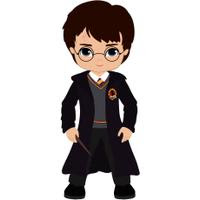



In [ ]:
content_recommender(4026, 8, corpus_tf_idf_without_names)

Our Target Movie ID is: 4026
Our Target Movie Title is ['Harry Potter and the Goblet of Fire']
Our Target Movie Summary is: 
 
  Now fourteen years old, Harry Potter dreams of an elderly man, Frank Bryce, who is killed after overhearing Lord Voldemort discussing plans with 
 Peter Wormtail Pettigrew and Barty Crouch Jr. The Quidditch World Cup allows Harry to take his mind off his nightmares until followers of 
 Voldemort known as Death Eaters terrorise the spectators campsites after the match, and Crouch Jr. summons the Dark Mark, a sign showing that 
 Voldemort is returning to power. At Hogwarts, headmaster Albus Dumbledore introduces ex-Auror Alastor Mad-Eye Moody as the new Defence Against 
 the Dark Arts teacher. In their first Defence Against the Dark Arts lesson, the students learn of the three Unforgivable Curses. The Imperius 
 Curse causes absence of free will, the Cruciatus Curse causes unbearable pain, and the final curse, Avada Kedavra, causes death. Dumbledore 
 announces

#### Πλέον τα αποτελέσματα αν και με χαμηλότερο βαθμό ομοιότητας είναι πλέον πιο στοχευμένα στην παρούσα ταινία. Oι προτεινόμενες ταινίες πλέον έχουν κοινή θεματολογία και δε βασίζονται απλά στο κοινό όνομα του πρωταγωνιστή όπως έγινε νωρίτερα.

#### Η ταινία Harry Potter and the Prisoner of Azkaban με ID=1979 παραμένει προτεινόμενη ως 4η αυτή τη φορά με ελάχιστη διαφορά ομοιότητας από την 1η προτεινόμενη. Να τονίσουμε πως οι υπόλοιπες ταινίες δυστυχώς δε μοιράζονται κοινή θεματολογία ούτε έχουν κοινές κατηγορίες.

#### Tέλος αλλάζουμε θεματολογία και αναζητούμε προτεινόμενες ταινίες για την ταινία Avatar με ID=1572

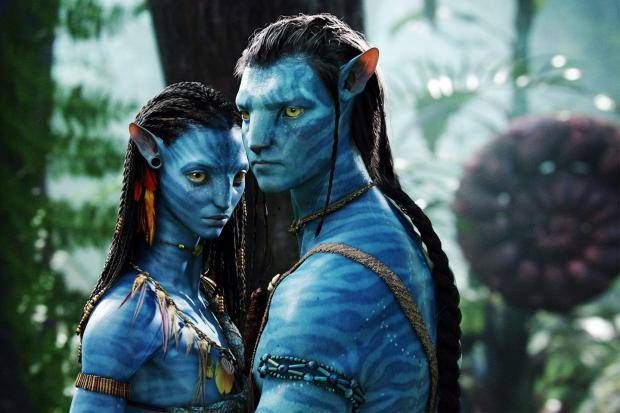

In [ ]:
content_recommender(1572, 8, corpus_tf_idf_without_names)

Our Target Movie ID is: 1572
Our Target Movie Title is ['Avatar']
Our Target Movie Summary is: 
 
  By 2154, humans have severely depleted Earths natural resources. The Resources Development Administration  mines for a valuable 
 mineral—unobtanium—on Pandora, a densely forested habitable moon orbiting the gas giant Polyphemus in the Alpha Centauri star system.<ref 
 nameJane|lastFamily Filmgoer|dateThe New York Times Company|url 3|workJanuary 9, 2010}} Pandora, whose atmosphere is poisonous to humans, is 
 inhabited by the Navi,  Archived version , 2010 and another in which Jake admits that the Navi will never abandon Hometree, Selfridge orders 
 Hometree destroyed. Despite Graces argument that destroying Hometree could damage the biological neural network native to Pandora, Selfridge 
 gives Jake and Grace one final chance to convince the Navi to evacuate before commencing the attack. While trying to warn the Navi, Jake 
 confesses to being a spy and the Navi take him and Grace capti

#### Εδώ αξιοσημείωτο αποτελεί πως η 1η προτεινόμενη ταινία αν και έχει διαφορετική υπόθεση και σενάριο από το Avatar έχει ένα κοινό στοιχείο με την ταινία αυτή το οποίο προκύπτει αν διαβάσει κανείς την περίληψη και των δύο αυτών ταινιών. Στην ταινία Here Comes The Bride οι πρωταγωνιστές αλλάζουν τα φυσικά τους σώματα και περνάνε σε άλλα σώματα κάτι το οποίο συμβαίνει και στον κύριο πρωταγωνιστή του Avatar. Ωστόσο πέρα από αυτό το κοινό σημείο οι ταινίες αυτές δυστυχώς δεν είναι όμοιες. Σε καμία περίπτωση δε θα προτείναμε σε κάποιον που είδε το Avatar να δει μια ρομαντική κωμωδία Φιλιππινέζικης παραγωγής. 

#### Kαταλήγουμε λοιπόν πως ο αλγόριθμος μας δουλεύει μέτρια, ωστόσο λαμβάνει υπόψιν την ομοιότητα ανάμεσα στις περιλήψεις. Θα μπορούσε να βελτιωθεί αν πάρουμε υπόψιν και άλλους παράγοντες όπως τα χαρακτηριστικά της ταινίας, τους ηθοποιούς και τον σκηνοθέτη με προϋπόθεση αυτές οι πληροφορίες να υπάρχουν στα dataset.

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

In [ ]:
!pip install -U gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

     |████████████████████████████████| 24.1 MB 1.5 MB/s            
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


#### Ας δούμε μερικά χαρακτηριστικά των μοντέλων μας.

In [ ]:
for model_name, model_data in sorted(gensim.downloader.info()['models'].items()):
    print(
        '%s (%d records): %s' % (
            model_name,
            model_data.get('num_records', -1),
            model_data['description']
        )
    )

__testing_word2vec-matrix-synopsis (-1 records): [THIS IS ONLY FOR TESTING] Word vecrors of the movie matrix.
conceptnet-numberbatch-17-06-300 (1917247 records): ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known as word embeddings) that can be used directly as a representation of word meanings or as a starting point for further machine learning. ConceptNet Numberbatch is part of the ConceptNet open data project. ConceptNet provides lots of ways to compute with word meanings, one of which is word embeddings. ConceptNet Numberbatch is a snapshot of just the word embeddings. It is built using an ensemble that combines data from ConceptNet, word2vec, GloVe, and OpenSubtitles 2016, using a variation on retrofitting.
fasttext-wiki-news-subwords-300 (999999 records): 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).
glove-twitter-100 (1193514 records): Pre-trained vectors based on  2B tweets, 27B toke

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

### Ως μοντέλο θα χρησιμοποιήσουμε το word2vec-google-news-300. Ένα μοντέλο με 3.000.000 λέξεις διάστασης 300.

In [ ]:
import gensim.downloader as api
model = api.load("word2vec-google-news-300")

[=================================-----------------] 66.5% 1106.5/1662.8MB downloaded

In [ ]:
# size of our model
print(len(model.index_to_key))
# example of one word in our model
print(model['story'])

3000000
[ 0.17578125  0.02453613 -0.16894531  0.03442383  0.12109375  0.05297852
  0.49414062  0.24707031  0.06689453  0.07714844 -0.14941406 -0.08984375
  0.12890625 -0.14257812 -0.16210938  0.16113281  0.00454712 -0.08349609
  0.01965332 -0.14257812  0.17871094 -0.00595093  0.26757812 -0.11279297
  0.06738281  0.06787109  0.03442383  0.16601562  0.18164062 -0.01123047
  0.06079102 -0.22070312 -0.00518799 -0.12792969  0.16113281  0.03735352
  0.171875    0.18164062  0.125       0.26757812 -0.01086426  0.12451172
 -0.11914062  0.15429688  0.11132812  0.23535156 -0.00558472 -0.16894531
  0.14648438 -0.1953125   0.19628906 -0.1328125  -0.07421875 -0.0008812
  0.28320312 -0.26171875  0.08203125  0.03393555  0.03686523 -0.34179688
  0.16796875  0.22949219  0.03540039 -0.04052734  0.09570312  0.14160156
  0.18359375 -0.01672363  0.21972656  0.16015625  0.04907227 -0.00436401
 -0.12597656 -0.26171875 -0.02807617  0.21679688  0.21191406 -0.06176758
  0.11376953  0.11328125  0.07519531 -0.0245

#### Save our Work So Far 

In [ ]:
import joblib

joblib.dump(preprocessed_corpus_without_names, 'preprocessed_corpus_without_names.pkl')
joblib.dump(corpus_tf_idf_without_names, 'corpus_tf_idf_without_names.pkl')
joblib.dump(vectorizer_without_names, 'vectorizer_without_names.pkl')


['vectorizer_without_names.pkl']

In [ ]:
!ls -lh

In [ ]:
import joblib

preprocessed_corpus_without_names = joblib.load('preprocessed_corpus_without_names.pkl')
corpus_tf_idf_without_names = joblib.load('corpus_tf_idf_without_names.pkl')
vectorizer_without_names = joblib.load('vectorizer_without_names.pkl')

In [ ]:
def build_tfw2v(mycorpus, vectors, embeddings_size):
  tfidf_vectors = []
  converted_words_of_vector = set(vectors.index_to_key)
  td_idf_features = set(vectorizer_without_names.get_feature_names_out())
  # summary_count holds the index for the ith movie
  summary_count = -1
  # for every summary of every movie
  for summary in  mycorpus:
    summary_count += 1
    specific_word2vec = np.zeros(embeddings_size)
    sum_of_tf_idf = 0
    words = summary.split()
    # current dictionary below maps every word to every tf_idf score for the current movie summary
    current_corpus_dict = dict(zip(vectorizer_without_names.get_feature_names_out(), corpus_tf_idf_without_names[summary_count]))
    # for every word in every summary
    for word in words:    
      # if the word is in the tfidf vocabulary
      if word in td_idf_features and word in converted_words_of_vector:
        # find the specific value of the word in corpus_tf_idf_without_names
        specific_tf_idf = current_corpus_dict[word]
        specific_word2vec += vectors[word]*specific_tf_idf
        sum_of_tf_idf += specific_tf_idf
    # if we actually changed something then sum_of_tf_idf will be greater than zero
    if sum_of_tf_idf !=0:
      specific_word2vec /= sum_of_tf_idf
    tfidf_vectors.append(specific_word2vec)
  return tfidf_vectors

In [ ]:
# build_tfw2v(preprocessed_corpus_without_names, model, 300)
corpus_word2vec_tf_idf = build_tfw2v(preprocessed_corpus_without_names, model, 300)

#### Aς τρέξουμε ξανά το recommender μας για το Avatar ξανά, αυτή τη φορά όμως θα χρησιμοποιήσουμε το νέο corpus_word2vec_tf_idf. Θυμόμαστε την προηγούμενη φορά που ζητήσαμε προτεινόμενες ταινίες για το Avatar η 1η προτεινόμενη ταινία δεν είχε κανένα κοινό με το Avatar.

In [ ]:
content_recommender(1572, 8, corpus_word2vec_tf_idf)

Our Target Movie ID is: 1572
Our Target Movie Title is ['Avatar']
Our Target Movie Summary is: 
 
  By 2154, humans have severely depleted Earths natural resources. The Resources Development Administration  mines for a valuable 
 mineral—unobtanium—on Pandora, a densely forested habitable moon orbiting the gas giant Polyphemus in the Alpha Centauri star system.<ref 
 nameJane|lastFamily Filmgoer|dateThe New York Times Company|url 3|workJanuary 9, 2010}} Pandora, whose atmosphere is poisonous to humans, is 
 inhabited by the Navi,  Archived version , 2010 and another in which Jake admits that the Navi will never abandon Hometree, Selfridge orders 
 Hometree destroyed. Despite Graces argument that destroying Hometree could damage the biological neural network native to Pandora, Selfridge 
 gives Jake and Grace one final chance to convince the Navi to evacuate before commencing the attack. While trying to warn the Navi, Jake 
 confesses to being a spy and the Navi take him and Grace capti

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


#### Παρατηρούμε πως πλέον τα αποτελέσματα είναι αρκετά κοντά στη θεματολογία της ταινίας Avatar. Αν και η 3η προτεινόμενη ταινία είναι μια παιδική οικογενειακή ταινία έχει αρκετά κοινά με το Avatar, όπως το γεγονός πως οι πρωταγωνιστές σώζονται από βέβαιο θάνατο καθώς και το γεγονός πως υπάρχει μια αλλαγή των φυσικών σωμάτων. Ωστόσο οι επόμενες προτεινόμενες ταινίες έχουν πάρα πολλά κοινά όσον αφορά τη θεματολογία τους και αυτό φαίνεται από τις κοινές κατηγορίες των ταινιών. Η τέταρτη προτεινόμενη ταινία έχει επίσης χαρακτηριστικά πολέμου μεταξύ δυο κόσμων και το ίδιο ισχύει για την 7η και 8η ταινία. Η 8η προτεινόμενη ταινία αν και διαφορετική έχει τα στοιχεία της περιπέτειας που είναι κοινά με το Avatar. H γενική εικόνα των προτεινόμενων ταινιών είναι πολύ καλύτερη από την περίπτωση του tf_idf.


#### Συνεχίζουμε με μία ακόμα αναζήτηση αυτή τη φορά για την ταινία: The Haunting με χρήση word2vec και χωρίς τη χρήση του.

In [ ]:
content_recommender(201, 8, corpus_word2vec_tf_idf)

Our Target Movie ID is: 201
Our Target Movie Title is ['The Haunting']
Our Target Movie Summary is: 
 
 The film begins with a voiceover by Dr. John Markway ([[Richard Johnson . Hill House was constructed by Hugh Crain as a home for his wife. She 
 died in an accident as she approached the house for the first time. Crain remarried. His second wife died after falling down the stairs. Crains 
 daughter, Abigail, lived in the house the rest of her life, never moving out of the nursery. She died calling for her absent nurse-companion. The 
 companion inherited the house, but hung herself in the library. Mrs. Sannerson inherited Hill House. It has stood empty for some time. The 
 voiceover ends. Dr. Markway is investigating paranormal activity. He wins permission from Mrs. Sannerson to occupy the house, but must take Luke 
 Sannerson   with him. Markway chooses two individuals to accompany him. One is the psychic, Theodora , who is also known as Theo. The other is 
 meek Eleanor Nell Lance 

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


#### Τα αποτελέσματα μας είναι αρκετά ενθαρρυντικά καθώς οι προτεινόμενες ταινίες έχουν κοινές κατηγορίες το Drama και το Horror. Οι προτεινόμενες ταινίες είναι ταινίες Θρίλλερ.

#### Ας δούμε τα αποτελέσματα μας στην περίπτωση που δε κάνουμε χρήση του word2vec.

In [ ]:
content_recommender(201, 8, corpus_tf_idf_without_names)

Our Target Movie ID is: 201
Our Target Movie Title is ['The Haunting']
Our Target Movie Summary is: 
 
 The film begins with a voiceover by Dr. John Markway ([[Richard Johnson . Hill House was constructed by Hugh Crain as a home for his wife. She 
 died in an accident as she approached the house for the first time. Crain remarried. His second wife died after falling down the stairs. Crains 
 daughter, Abigail, lived in the house the rest of her life, never moving out of the nursery. She died calling for her absent nurse-companion. The 
 companion inherited the house, but hung herself in the library. Mrs. Sannerson inherited Hill House. It has stood empty for some time. The 
 voiceover ends. Dr. Markway is investigating paranormal activity. He wins permission from Mrs. Sannerson to occupy the house, but must take Luke 
 Sannerson   with him. Markway chooses two individuals to accompany him. One is the psychic, Theodora , who is also known as Theo. The other is 
 meek Eleanor Nell Lance 

#### Σε αυτή την περίπτωση του tf_idf βλέπουμε ο recommender μας επιστρέφει ικακοποιητικά αποτελέσματα και μάλιστα η 1η προτεινόμενη ταινία είναι ίδια με την 1 προτεινόμενη ταινία όταν κάναμε χρήση των word embeddings.

#### Αναζητούμε ταινίες προτεινόμενες για την ταινία Wonder Woman με ID=3697.
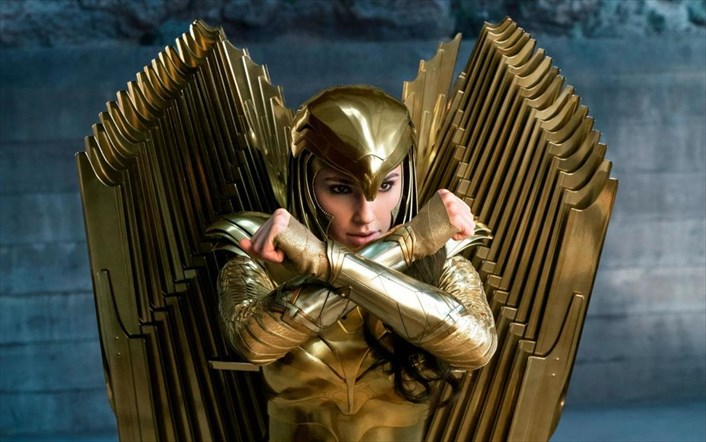

In [ ]:
content_recommender(3697, 8, corpus_word2vec_tf_idf)

Our Target Movie ID is: 3697
Our Target Movie Title is ['Wonder Woman']
Our Target Movie Summary is: 
 
 Centuries ago, the Amazons, a proud and fierce race of warrior women, led by Queen Hippolyta , battled Ares , the God of War, and his army. During 
 the battle, Hippolyta beheaded her son, Thrax , whom Ares forcibly conceived with her, and then defeated the God of War himself. Zeus , however, 
 prevented her from killing Ares. Instead, Hera  bound his powers with magic bracers so that he was deprived of his ability to draw power from the 
 aura of violence and death he could instigate, and only another god could release him. In compensation, the Amazons were granted the island of 
 Themyscira, where they could be eternally youthful and isolated from Man in the course of their duty of holding Ares prisoner for all eternity. 
 Later, Hippolyta was granted a daughter, Princess Diana , whom she shaped from the sand of the sea shore and gave life with her own blood. Over a 
 millennium l

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


#### Ξανά τα αποτελέσματα είναι αρκετά ενθαρρυντικά όπου προτείνονται ταινίες με δράση και φαντασία. Θα θέλαμε και ταινίες με υπερήρωες ως προτεινόμενες αλλα ωστόσο είμαστε ικανοποιημένοι. Χαρακτηριστικό αποτελεί η ταινία King Maker όπου ο πρωταγωνιστής ξεβράζεται σε ένα νησί κάτι το οποίο συμβαίνει και στη Wonder Woman με τον πρωταγωνιστή να ξεβράζεται στο νησί με τις Αμαζόνες.

#### Ας δούμε τις προτεινόμενες ταινίες με tf_idf για την ίδια ταινία.

In [ ]:
content_recommender(3697, 8, corpus_tf_idf_without_names)

Our Target Movie ID is: 3697
Our Target Movie Title is ['Wonder Woman']
Our Target Movie Summary is: 
 
 Centuries ago, the Amazons, a proud and fierce race of warrior women, led by Queen Hippolyta , battled Ares , the God of War, and his army. During 
 the battle, Hippolyta beheaded her son, Thrax , whom Ares forcibly conceived with her, and then defeated the God of War himself. Zeus , however, 
 prevented her from killing Ares. Instead, Hera  bound his powers with magic bracers so that he was deprived of his ability to draw power from the 
 aura of violence and death he could instigate, and only another god could release him. In compensation, the Amazons were granted the island of 
 Themyscira, where they could be eternally youthful and isolated from Man in the course of their duty of holding Ares prisoner for all eternity. 
 Later, Hippolyta was granted a daughter, Princess Diana , whom she shaped from the sand of the sea shore and gave life with her own blood. Over a 
 millennium l

#### Τα αποτελέσματα σε αυτή την περίπτωση είναι καλά μέχρι την 4η προτεινόμενη ταινία. Ωστόσο η 5η,6η,7η και 8η ταινία δεν είναι τόσο όμοιες. Αντίστοιχα θα μπορούσαμε να πούμε πως και η 3η προτεινόμενη ταινία Mummy Returns αν και έχει παρόμοιες κατηγορίες δεν είναι τόσο κοινή. Δύσκολα θα λέγαμε σε κάποιον που του αρέσε η Wonder Woman να δει το The Mummy Returns.

#### Παρακάτω βλέπουμε προτεινόμενες ταινίες για την ταινία Sniper 2, αρχικά με word embeddings και ύστερα με tf_idf.

In [ ]:
content_recommender(1266, 8, corpus_word2vec_tf_idf)

Our Target Movie ID is: 1266
Our Target Movie Title is ['Sniper 2']
Our Target Movie Summary is: 
 
 Former U.S. Marine Corps scout sniper Thomas Beckett , who was discharged after his finger was amputated in the first film, is met by CIA officer 
 James Eckles  and Colonel David McKenna  at his home in Montana. Despite losing his index finger he uses to shoot, Beckett still has the 
 capability of firing a gun . Considering this, along with his impressive career from his time in the Marine Corps, Beckett is given a mission to 
 assassinate renegade Serbian General Mile Valstoria , who is responsible for conducting hit-and-run ethnic cleansing operations in 
 Muslim-populated areas in Serbia. The CIA fears that Valstorias actions are threatening to inflame a larger conflict in the region. Given the 
 details of the mission, Beckett requests that an additional man, a spotter, must come with him. At the U.S. embassy in Berlin, Beckett is 
 introduced to his spotter, Jake Cole , an experi

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


#### Εξίσου ενθαρρυντικά τα αποτελέσματα με τις ταινίες που προτείνονται να έχουν κοινή θεματολογία δηλαδή δράση, πιστολίδι και πόλεμο.

#### Ας δούμε τα αποτελέσματα με χρήση td_idf.

In [ ]:
content_recommender(1266, 8, corpus_tf_idf_without_names)

Our Target Movie ID is: 1266
Our Target Movie Title is ['Sniper 2']
Our Target Movie Summary is: 
 
 Former U.S. Marine Corps scout sniper Thomas Beckett , who was discharged after his finger was amputated in the first film, is met by CIA officer 
 James Eckles  and Colonel David McKenna  at his home in Montana. Despite losing his index finger he uses to shoot, Beckett still has the 
 capability of firing a gun . Considering this, along with his impressive career from his time in the Marine Corps, Beckett is given a mission to 
 assassinate renegade Serbian General Mile Valstoria , who is responsible for conducting hit-and-run ethnic cleansing operations in 
 Muslim-populated areas in Serbia. The CIA fears that Valstorias actions are threatening to inflame a larger conflict in the region. Given the 
 details of the mission, Beckett requests that an additional man, a spotter, must come with him. At the U.S. embassy in Berlin, Beckett is 
 introduced to his spotter, Jake Cole , an experi

#### Eξίσου ενθαρρυντικά αποτελέσματα με χρήση του tf_idf. Οι ταινίες αν και διαφορετικές από εκείνες που είχαμε ως προτεινόμενες με word embeddings έχουν αρκετά κοινή θεματολογία.

#### Tέλος ας δούμε ταινίες σχετικά με τους 300.
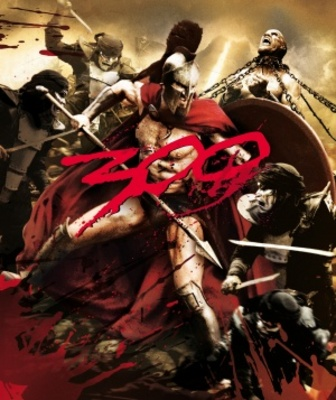

In [ ]:
content_recommender(1865, 8, corpus_word2vec_tf_idf)

Our Target Movie ID is: 1865
Our Target Movie Title is ['300']
Our Target Movie Summary is: 
 
  Dilios, a Spartan soldier, narrates the story of Leonidas from his boyhood to becoming a king of Sparta. Years later, a Persian messenger arrives 
 at the gates of Sparta, demanding the submission of Sparta to King Xerxes. In response to this demand, Leonidas kicks the messenger into a large 
 well. Knowing this will prompt a Persian attack, Leonidas visits the Ephors—ancient leprosy-ridden priests whose blessing he needs before the 
 Spartan council will authorize going to war. He proposes they repel the numerically superior Persians by using the terrain of Thermopylae  and 
 funneling the Persians into a narrow pass between the rocks and the sea. The Ephors consult the Oracle, who decrees that Sparta must not go to war 
 during their religious festival Carnea. As Leonidas departs, two agents of Xerxes appear—one of them, Theron, a Spartan—who bribe the Ephors with 
 concubines and money. 

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


#### Oι προτεινόμενες ταινίες σε αυτή την περίπτωση δεν είναι τόσο όμοιες όσο θα θέλαμε παρόλο που χρησιμοποιήσαμε word embeddings. Κάποιες ταινίες έχουν ιστορικό περιεχόμενο, έχουν δράση και φαντασία όπως γίνεται στους 300. Η 3η προτεινόμενη ταινία έχει στοιχεία από την ελληνική μυθολογία, ωστόσο οι πρώτες δυο δε μας ικανοποιούν.

#### Aς δούμε παρακάτω τα αποτελέσματα με χρήση tf_idf.

In [ ]:
content_recommender(1865, 8, corpus_tf_idf_without_names)

Our Target Movie ID is: 1865
Our Target Movie Title is ['300']
Our Target Movie Summary is: 
 
  Dilios, a Spartan soldier, narrates the story of Leonidas from his boyhood to becoming a king of Sparta. Years later, a Persian messenger arrives 
 at the gates of Sparta, demanding the submission of Sparta to King Xerxes. In response to this demand, Leonidas kicks the messenger into a large 
 well. Knowing this will prompt a Persian attack, Leonidas visits the Ephors—ancient leprosy-ridden priests whose blessing he needs before the 
 Spartan council will authorize going to war. He proposes they repel the numerically superior Persians by using the terrain of Thermopylae  and 
 funneling the Persians into a narrow pass between the rocks and the sea. The Ephors consult the Oracle, who decrees that Sparta must not go to war 
 during their religious festival Carnea. As Leonidas departs, two agents of Xerxes appear—one of them, Theron, a Spartan—who bribe the Ephors with 
 concubines and money. 

#### Tα αποτελέσματα με tf_idf είναι άκρως ενθαρρυντικά με τις πρώτες 5 προτεινόμενες να έχουν πολλά κοινά με τους 300. Μάλιστα η 4η είναι το sequel της ταινίας, κάτι το οποίο δε κατάφερε να εντοπίσει ο recommender με word embeddings.

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nir-picking:](https://www.merriam-webster.com/dictionary/nit-picking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

### Η προεπεξεργασία που πραγματοποιήσαμε στα κείμενα είναι η παρακάτω:


1.   #### Αρχικά μετατρέψαμε τα κεφαλαία γράμματα σε πεζά.
2.   #### Ύστερα αφαιρέσαμε τις λέξεις stopwords από τις περιλήψεις. Σε πρώτο στάδιο δεν αφαιρέσαμε τα ονόματα, ανδρικά και γυναικεία.
3.   #### Στη συνέχεια αφαιρέσαμε τυχόν σημεία στίξης που μπορεί να απέμειναν στα κείμενα μας.
4.   #### Τέλος πραγματοποιήσαμε lemmatization διότι μετέπειτα θα μας βοηθούσε αρκετά με τα word embeddings.
5.   #### Ωστόσο μετά από ελέγχους που κάναμε στο recommender μας παρατηρήσαμε πως προτεινόμενες ταινίες είχαν σα βάση τα κοινά ονόματα των χαρακτήρων, οπότε αφαιρέσαμε και τα ανδρικά και γυναικεία ονόματα. Το αρχείο stopwords.txt το δημιουργήσαμε βασισμένοι στο άρθρο της σελίδας https://www.matthewjockers.net/macroanalysisbook/expanded-stopwords-list/
6.   #### Tέλος επεξεργαστήκαμε και τις παραμέτρους min_df και max_df της TfidfVectorizer. Επιλέξαμε να δώσουμε στην max_df την τιμή 0.5 τυπικά, δηλαδή να κόβει τις λέξεις που εμφανίζονται τουλάχιστον στα μισά κείμενα. Παρατηρήσαμε μηδαμινές διαφορές στα αποτελέσματα μας όταν μεταβάλλαμε τη max_df. Ωστόσο στη min_df δώσαμε την τιμη 14 δηλαδή κόβουμε τις λέξεις που εμφανίζονται λιγότερες από 14 φορές συνολικά σε όλα τα κείμενα. Για τον καθορισμό της τιμής αυτής κάναμε αρκετούς ελέγχους προτού καταλήξουμε. Οι έλεγχοι είχαν ως βάση την ομοιότητα των ταινιών ως προς τη θεματολογία. Το τελικό μας διάνυσμα είχε μήκος 5373.



#### Γενικότερα από ελέγχους που κάναμε υπήρχαν περιπτώσεις όπου πήραμε καλές προτεινόμενες ταινίες. Παραπάνω είδαμε πως για τις ταινίες Sniper2,The Haunting και 300 είχαμε στο τοπ5 προτεινόμενες ταινίες με κοινή θεματολογία. Υπάρχουν αρκετές ταινίες όπου ο tf_idf recommender στέκεται με αξιοπρέπεια αλλά στις περισσότερες των περιπτώσεων αδυνατεί να μας δώσει καλά αποτελέσματα. Θυμόμαστε τις άσχημες προτάσεις στο Avatar και στο Harry Potter and the Goblet of Fire όπου αδυνατούσε να προτείνει ένα καλό τοπ5 ταινιών.

#### Στα πλεονεκτήματα του tf_idf μπορούμε να πούμε πως είναι η ευκολία υπολογισμού ομοιότητας ανάμεσα στις περιλήψεις και πως σε πολύ εύκολες κατηγορίες όπως τα θριλλερ μπορεί να βρει πιο εύκολα προτεινόμενες ταινίες καθώς οι λέξεις κλειδιά είναι πολύ όμοιες.

#### Στα μειονεκτήματα βρίσκεται το γεγονός πως επιλέγει καθαρά ομοιότητα ανάμεσα στις λέξεις και αδυνατεί να εξάγει σημασιολογικές ομοιότητες όπως γίνεται με τα words embeddings. Επίσης το μεγάλο μήκος του διανύσματος είναι ένα μειονέκτημα, μη ξεχνάμε πως σε αυτά τα αποτελέσματα καταλήξαμε με διάνυσμα μήκους 5373. Ένα διάνυσμα πολύ αραιό το οποίο μας οδηγεί σε χαμηλή ομοιότητα συνημιτόνου. Μάλιστα ανά ταινία το μεγαλύτερο τμήμα του έχει μηδενικές τιμές.

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


#### Από την άλλη μεριά ο word2vec recommender μας απεικονίζει καλύτερα αποτελέσματα. Θυμόμαστε πως στο Avatar επέστρεψε ταινίες πιο κοινές από ότι ο tf_idf. Το ίδιο συνέβη και για την ταινία Wonder Woman. Παρατηρούμε πως ενώ πέσαμε σε διάσταση 300 έχουμε πλέον πολύ αυξημένη ομοιότητα συνημιτόνου. Από τα αρκετά παραδείγματα που τρέξαμε μόλις σε ένα παράδειγμα, στην ταινία 300 οι προτεινόμενες ταινίες δεν ήταν τόσο όμοιες όσο αυτές που μας πρότεινε ο tf_idf. 

#### Να τονίσουμε επίσης πως από τα παραδείγματα που τρέξαμε αλλάξαμε πολλές φορές το μοντέλο word2vec που χρησιμοποιήσαμε. Παρατηρήσαμε πως όσο αυξανόταν η διάσταση, από 50 σε 100 και από 100 σε 300, πετυχαίναμε καλύτερα αποτελέσματα. Καταλήξαμε να χρησιμοποιήσουμε ως μοντέλο το word2vec-google-news-300. Με αυτό το μοντέλο πέσαμε ελάχιστα στην ομοιότητα συνημιτόνου που είχαν οι τοπ 8 προτεινόμενες ταινίες μας αλλά πετύχαμε ελάχιστα καλύτερη ομοιότητα. Χαρακτηριστικό της επιλογής μας αποτέλεσε πως οι προτεινόμενες ταινίες στην ταινία 300 με άλλα μοντέλα είχαν σχεδόν μηδαμινή ομοιότητα. Αυτό το γεγονός μας προβλημάτισε και μας οδήγησε σε αναζήτηση και άλλων μοντέλων. Τελικά με χρήση του μοντέλου word2vec-google-news-300 διατηρήσαμε παρόμοια αποτελέσματα σε όλα τα παραδείγματα μας και ταυτόχρονα καταφέραμε στην ταινία 300 να μας επιστραφούν κάπως καλύτερα αποτελέσματα.

#### Συμπερασματικά μπορούμε να πούμε πως ο recommender μας με word embeddings μας επέστρεψε καλύτερα αποτελέσματα στα περισσότερα παραδείγματα που απεικονίσαμε. Τρέξαμε και άλλα παραδείγματα τα οποία αν και δεν απεικονίζουμε εδώ μας οδηγούν στο ίδιο συμπέρασμα. Ωστόσο όπως αναφέραμε και νωρίτερα προτείνουμε ταινίες με βάση την περίληψή τους και αγνοούμε τις κατηγορίες τους. Ο recommender μας μπορεί να βελτιωθεί περαιτέρω αν συνδυάσουμε την ομοιότητα συνημιτόνου όχι μόνο στις περιλήψεις αλλά και στις κατηγορίες. Το ίδιο το dataset μας επίσης είναι πιθανό να μην περιέχει τις ταινίες που θα θέλαμε. Θυμόμαστε στην ταινία Wonder Woman δε μας προτάθηκε καμία άλλη ταινία με υπερήρωες, πιθανόν γιατί να μην εμπεριέχονται στις 5000 ταινίες που έχουμε στη διάθεση μας. Θα μπορούσαμε επιπλέον να προτείνουμε ταινίες και με βάση ηθοποιούς, σκηνοθέτη, χωρά παραγωγής, δεκαετία γυρίσματος κτλ.

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

## Υπενθυμίζουμε πως στο πρώτο μέρος το καλύτερο επεξεργασμένο corpus το αποκτήσαμε αφού αφαιρέσαμε ανδρικά και γυναικεία ονόματα. Το συγκεκριμένο corpus το είχαμε ονομάσει `corpus_tf_idf_without_names`

In [ ]:
import numpy as np

def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
final_set = build_final_set(corpus_tf_idf_without_names)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [ ]:
final_set.shape

(5000, 5695)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [ ]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

     |████████████████████████████████| 6.1 MB 24.2 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp37-cp37m-linux_x86_64.whl size=481124 sha256=1d166af387632d9306bfef5486d5c868778cdbc0dbc0e318d2956566edf5c279
  Stored in directory: /root/.cache/pip/wheels/d5/81/eb/22b023e9cac575c4b87d3f9a7318094124e5d8cf90600726fa
Successfully built somoclu


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

### Θα ξεκινήσουμε με ένα χάρτη 10Χ10, 100epochs και ένα υποσύνολο των ταινιών(2500).


In [ ]:
half_final_set = build_final_set(corpus_tf_idf_without_names, 2500)
print(half_final_set.shape)

(2500, 5695)


In [ ]:
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som.train(half_final_set, epochs=100)

CPU times: user 7min 31s, sys: 1.44 s, total: 7min 33s
Wall time: 3min 50s


In [ ]:
# save every map
joblib.dump(som, 'som.pkl')

['som.pkl']

### Συνεχίζουμε με ένα χάρτη 10Χ10, 100epochs και όλες τις ταινίες.

In [ ]:
n_rows, n_columns = 10, 10
som_10_full = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som_10_full.train(final_set, epochs=100)

CPU times: user 14min 49s, sys: 2.87 s, total: 14min 52s
Wall time: 7min 44s


In [ ]:
# save every map
joblib.dump(som_10_full, 'som_10_full.pkl')

### Συνεχίζουμε με ένα χάρτη 15Χ15, 100epochs και όλες τις ταινίες.

In [ ]:
n_rows, n_columns = 15, 15
som_15_full = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som_15_full.train(final_set, epochs=100)

CPU times: user 33min 15s, sys: 6.69 s, total: 33min 22s
Wall time: 17min 16s


In [ ]:
# save every map
joblib.dump(som_15_full, 'som_15_full.pkl')

['som_15_full.pkl']

### Συνεχίζουμε με ένα χάρτη 20Χ20, 100epochs και όλες τις ταινίες.

In [ ]:
n_rows, n_columns = 20, 20
som_20_full = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som_20_full.train(final_set, epochs=100)

CPU times: user 1h 1min 40s, sys: 13.7 s, total: 1h 1min 54s
Wall time: 31min 30s


In [ ]:
# save every map
joblib.dump(som_20_full, 'som_20_full.pkl')

['som_20_full.pkl']

### Συνεχίζουμε με ένα χάρτη 25Χ25, 100epochs και όλες τις ταινίες.

In [ ]:
n_rows, n_columns = 25, 25
som_25_full = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som_25_full.train(final_set, epochs=100)

CPU times: user 1h 39min 47s, sys: 25.6 s, total: 1h 40min 12s
Wall time: 51min 44s


In [ ]:
# save every map
joblib.dump(som_25_full, 'som_25_full.pkl')

['som_25_full.pkl']

### Tέλος ορίζουμε ένα χάρτη 30Χ30, 100epochs και όλες τις ταινίες.

In [ ]:
n_rows, n_columns = 30, 30
som_30_full = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som_30_full.train(final_set, epochs=100)

CPU times: user 2h 23min 32s, sys: 33.8 s, total: 2h 24min 5s
Wall time: 1h 14min 23s


In [ ]:
# save every map
joblib.dump(som_30_full, 'som_30_full.pkl')

['som_30_full.pkl']

## Load our som data

In [ ]:
import joblib

som_10_full = joblib.load('som_10_full.pkl')
som_15_full = joblib.load('som_15_full.pkl')
som_20_full = joblib.load('som_20_full.pkl')
som_25_full = joblib.load('som_25_full.pkl')
som_30_full = joblib.load('som_30_full.pkl')


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


### Best matching units For 10X10 Grid


In [ ]:
bmus_10_full = som_10_full.bmus
ubmus_10_full, indices_10_full = np.unique(bmus_10_full, return_inverse=True, axis=0)
print(indices_10_full)

[69 93 51 ... 86 19 69]


### Best matching units For 15X15 Grid


In [ ]:
bmus_15_full = som_15_full.bmus
ubmus_15_full, indices_15_full = np.unique(bmus_15_full, return_inverse=True, axis=0)
print(indices_15_full)

[182 117  29 ... 158 123 181]


### Best matching units For 20X20 Grid


In [ ]:
bmus_20_full = som_20_full.bmus
ubmus_20_full, indices_20_full = np.unique(bmus_20_full, return_inverse=True, axis=0)
print(indices_20_full)

[103  54 233 ...  18 222 102]


### Best matching units For 25X25 Grid


In [ ]:
bmus_25_full = som_25_full.bmus
ubmus_25_full, indices_25_full = np.unique(bmus_25_full, return_inverse=True, axis=0)
print(indices_25_full)

[115 255   5 ... 336 192 133]


### Best matching units For 30X30 Grid


In [ ]:
bmus_30_full = som_30_full.bmus
ubmus_30_full, indices_30_full = np.unique(bmus_30_full, return_inverse=True, axis=0)
print(indices_30_full)
print(ubmus_30_full)

[609 396 242 ... 594 447 583]
[[ 0  0]
 [ 0  1]
 [ 0  2]
 ...
 [29 27]
 [29 28]
 [29 29]]



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.



## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

### Για κάθε Grid θα ξεκινήσουμε από χαμηλό k και θα πορευτούμε προς υψηλό k.

### Δημιουργήσαμε τη συνάρτηση show_results για να αυτοματοποιήσουμε την απεικόνιση των U-matrix.

### Τέλος για κάθε som που έχουμε παράγει θα ομαδοποιούμε τους νευρώνες με τον αλγόριθμο kMeans για k=10, k=20, k=25. Δε θα ξεπεράσουμε το k=25 κυρίως για οπτικούς λόγους, δηλαδή να είναι εφικτό από το ανθρώπινο μάτι να αξιολογήσει σε ένα ικανοποιητικό βαθμό τους χάρτες.

### Παρακάτω παραάθετουμε διάφορους χάρτες προκειμένου να καταλήξουμε σε ένα καλό χάρτη.

In [ ]:
from sklearn.cluster import KMeans
from IPython.display import display

def show_result(dimensions, k, array, fig_size=(15, 15)):
  algorithm = KMeans(n_clusters=k)
  array.cluster(algorithm=algorithm)
  array.view_umatrix(bestmatches=True, colorbar=True, figsize=fig_size)
  clusters = array.clusters
  print(f'\n For {dimensions} Grid and k = {k} our clusters are \n')
  print(str(array.clusters) + "\n")
  values, counts = np.unique(clusters, return_counts=True)
  print("Cluster sorted by increasing number of neurons:")
  print("Cluster index")
  print("Number of neurons")  
  dict_display = {}
  # i actually is the values
  for i in range(len(counts)):
    dict_display[i] = counts[i].flatten()
  df = pd.DataFrame(dict_display).style.hide_index()
  display(df)

### **Δοκιμάζουμε 10Χ10 Grid και k=10**.

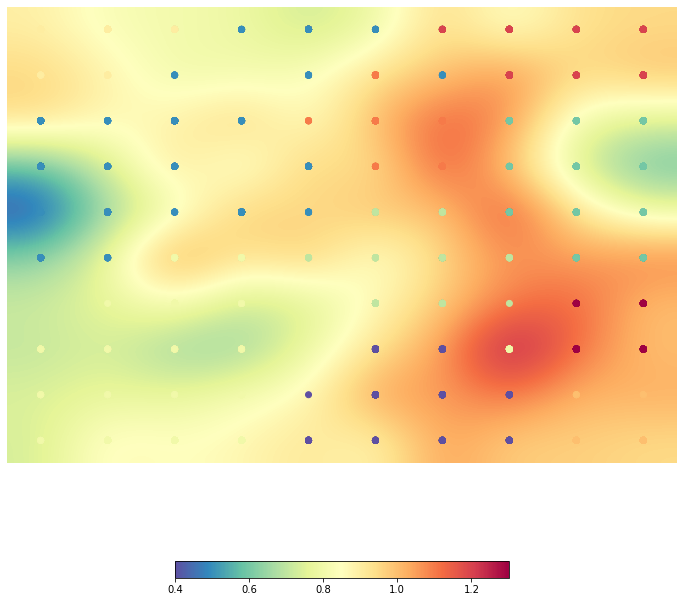


 For 10X10 Grid and k = 10 our clusters are 

[[5 5 5 1 1 1 8 8 8 8]
 [5 5 1 1 1 7 1 8 8 8]
 [1 1 1 1 7 7 7 2 2 2]
 [1 1 1 1 1 7 7 2 2 2]
 [1 1 1 1 1 3 3 2 2 2]
 [1 1 4 4 3 3 3 3 2 2]
 [4 4 4 4 3 3 3 3 9 9]
 [4 4 4 4 4 0 0 4 9 9]
 [4 4 4 4 0 0 0 0 6 6]
 [4 4 4 4 0 0 0 0 6 6]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons


In [ ]:
k = 10
show_result("10X10", k, som_10_full, (12, 12))

### **Δοκιμάζουμε 10Χ10 Grid και k=20**.

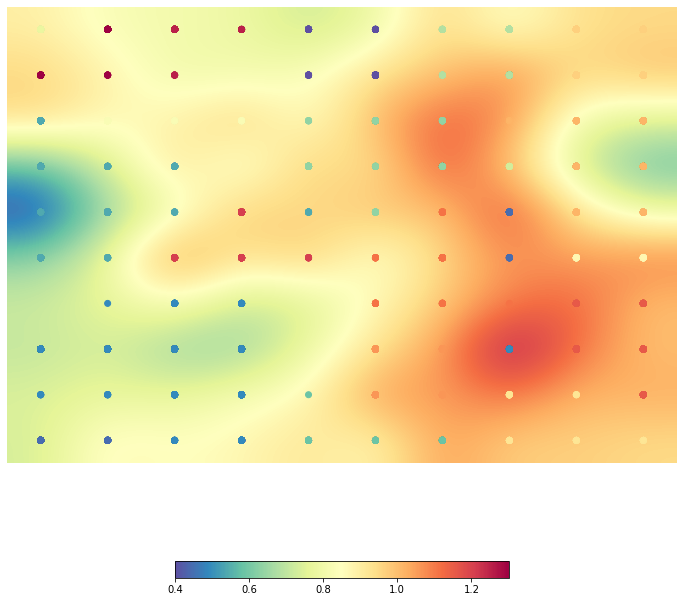


 For 10X10 Grid and k = 20 our clusters are 

[[ 8 19 18 18  0  0  6  6 12 12]
 [19 19 18 18  0  0  6  6 12 12]
 [ 3  9  9  9  5  5  5 13 13 13]
 [ 3  3  3  3  5  5  5  7 13 13]
 [ 3  3  3 17  3  5 15  1 13 13]
 [ 3  3 17 17 17 15 15  1 10 10]
 [ 2  2  2  2  2 15 15 15 16 16]
 [ 2  2  2  2  2 14 14  2 16 16]
 [ 2  2  2  2  4 14 14 11 11 16]
 [ 1  1  2  2  4  4  4 11 11 11]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons


In [ ]:
k = 20
show_result("10X10", k, som_10_full, (12, 12))

### **Δοκιμάζουμε 10Χ10 Grid και k=25**.

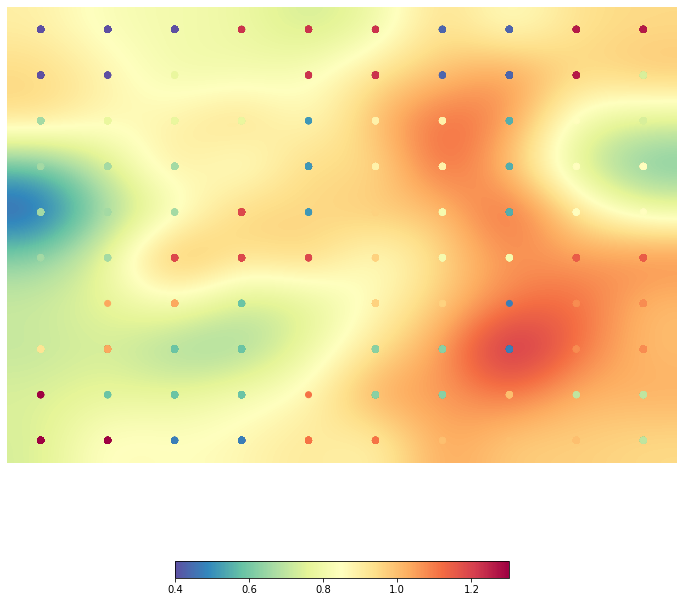


 For 10X10 Grid and k = 25 our clusters are 

[[ 0  0  0 22 22 22  1  1 23 23]
 [ 0  0 10 10 22 22  1  1 23  9]
 [ 7 10 10 10  3 13 13  4 12  9]
 [ 7  7  7  3  3 13 13  4 12 12]
 [ 7  7  7 21  3 15 11  4 12 12]
 [ 7  7 21 21 21 15 11 11 20 20]
 [14 17 17  5 15 15 15  2 18 18]
 [14 17  5  5  5  6  6  2 18 18]
 [24  5  5  5 19  6  6 16  8  8]
 [24 24  2  2 19 19 16 16 16  8]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons


In [ ]:
k = 25
show_result("10X10", k, som_10_full, (12, 12))

### **Σχολιασμός για το Grid 10X10**

#### Γενικότερα δοκιμάσαμε παραπάνω από 3 διαφορετικούς συνδυασμούς, ωστόσο κάθε φορά παρατηρούμε πως παρόλο που αυξάνουμε το k στο kMeans πετυχαίνουμε πολύ συχνά ίδια κατηγορία clusters πάνω σε κόκκινες περιοχές κάτι το οποίο δε το επιθυμούμε. Επίσης έχουμε μια πολύ μεγάλη κόκκινη περιοχή και ελάχιστες μπλε-πράσινες. Ιδανικά θα θέλαμε να έχουμε περισσότερες μπλε-πράσινες περιοχές και μικρότερες κόκκινες περιοχές. Επίσης πάνω στις κόκκινες περιοχές θα θέλαμε να έχουμε αλλαγή της κατηγορίας του cluster, καθώς εκεί έχουμε το όριο ανάμεσα στα clusters.

#### Συνεπώς συνεχίζουμε την οπτική βελτίωση για μεγαλύτερο Grid.

### **Δοκιμάζουμε 15Χ15 Grid και k=10**.

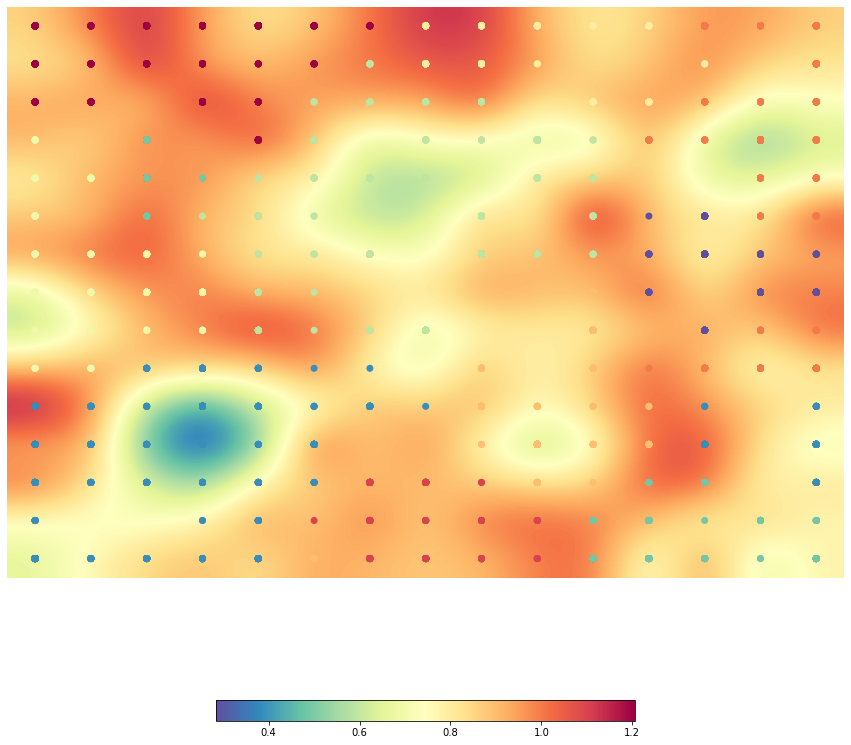


 For 15X15 Grid and k = 10 our clusters are 

[[9 9 9 9 9 9 9 5 5 5 5 5 7 7 7]
 [9 9 9 9 9 9 3 5 5 5 5 5 5 7 7]
 [9 9 9 9 9 3 3 3 3 3 5 5 7 7 7]
 [4 2 2 9 9 3 3 3 3 3 3 7 7 7 7]
 [4 4 2 2 3 3 3 3 3 3 3 7 7 7 7]
 [4 4 2 3 3 3 3 3 3 3 3 0 0 7 7]
 [4 4 4 4 3 3 3 3 3 3 3 0 0 0 0]
 [4 4 4 4 3 3 3 3 3 3 6 0 0 0 0]
 [4 4 4 4 3 3 3 3 3 6 6 6 0 7 7]
 [4 4 1 1 1 1 1 3 6 6 6 7 7 7 7]
 [1 1 1 1 1 1 1 1 6 6 6 6 1 1 1]
 [1 1 1 1 1 1 1 8 6 6 6 6 1 1 1]
 [1 1 1 1 1 1 8 8 8 6 6 2 2 2 1]
 [1 1 1 1 1 8 8 8 8 8 2 2 2 2 2]
 [1 1 1 1 1 6 8 8 8 8 2 2 2 2 2]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons


In [ ]:
k = 10
show_result("15X15", k, som_15_full, (15, 15))

### **Δοκιμάζουμε 15Χ15 Grid και k=20**.

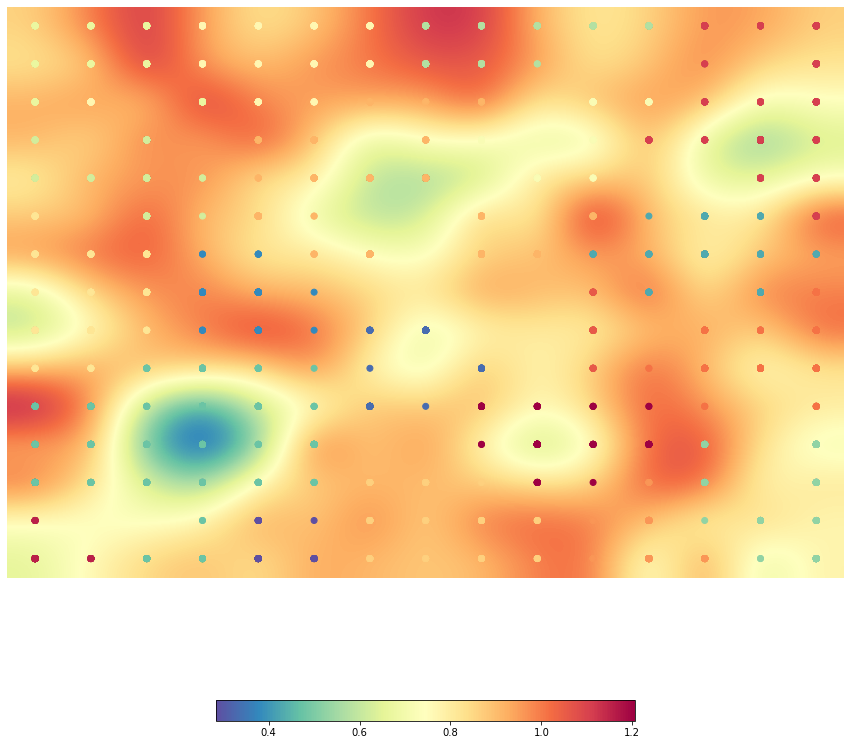


 For 15X15 Grid and k = 20 our clusters are 

[[ 8  8  8 10 10 10 10  6  6  6  6  6 17 17 17]
 [ 8  8  8 10 10 10 10  6  6  6  9  6 17 17 17]
 [ 8 10 10  8 10 10 13 13 13  9  9  9 17 17 17]
 [ 7  7  7 13 13 13 13 13  9  9  9 17 17 17 17]
 [ 7  7  7  7 13 13 13 13 13  9  9 17 17 17 17]
 [11  7  7  7 13 13 13 13 13 13 13  3  3  3 17]
 [11 11 11  2  2 13 13 13 13 13  3  3  3  3  3]
 [11 11 11  2  2  2 13  1 13 13 16  3  3  3 15]
 [11 11 11  2  2  2  1  1  1 16 16 16 15 15 15]
 [11 11  4  4  4  4  1  1  1 16 16 15 15 15 15]
 [ 4  4  4  4  4  4  1  1 19 19 19 19 15 15 15]
 [ 4  4  4  4  4  4  4 12 19 19 19 19  5  5  5]
 [ 4  4  4  4  4  4 12 12 12 19 19 14  5  5  5]
 [18 18  4  4  0  0 12 12 12 12 14 14  5  5  5]
 [18 18  4  4  0  0 12 12 12 12 14 14 14  5  5]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons


In [ ]:
k = 20
show_result("15X15", k, som_15_full, (15, 15))

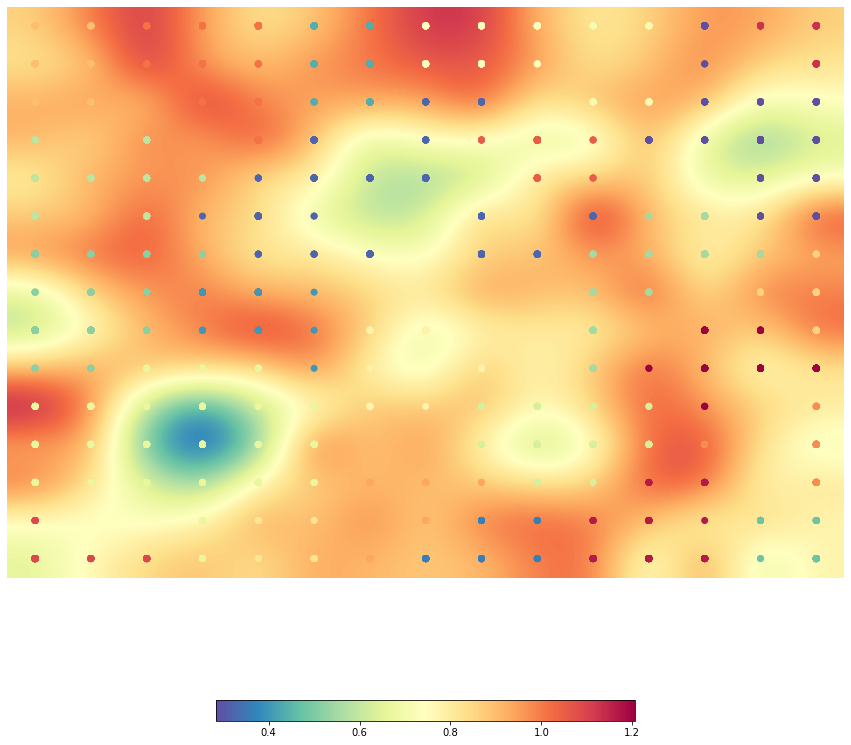


 For 15X15 Grid and k = 25 our clusters are 

[[16 16 19 19 19  4  4 12 12 12 11 11  0 22 22]
 [16 16 19 19 19  4  4 12 12 12 11 11  0 22 22]
 [16 16 19 19 19  4  4  1  1 20 11 11  0  0  0]
 [ 8  8  8 19 19  1  1  1 20 20 20  0  0  0  0]
 [ 8  8  8  8  1  1  1  1  1 20 20  0  0  0  0]
 [ 8  8  8  1  1  1  1  1  1  1  1  7  7  0  0]
 [ 6  6  6  6  1  1  1  1  1  1  7  7  7  7 15]
 [ 6  6  6  3  3  3  1 13  1  1  7  7  7 15 15]
 [ 6  6  6  3  3  3 13 13 13  7  7  7 24 24 15]
 [ 6  6 10 10 10  3 13 13 13  9  7 24 24 24 24]
 [10 10 10 10 10 10 13 13  9  9  9  9 24 24 18]
 [10 10 10 10 10 10 10 17  9  9  9  9 18 18 18]
 [10 10 10 10 10 10 17 17 17  9  9 23 23  5 18]
 [21 21 10 10 14 14 17 17  2  2 23 23 23  5  5]
 [21 21 21 10 14 14 17  2  2  2 23 23 23  5  5]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons


In [ ]:
k = 25
show_result("15X15", k, som_15_full, (15, 15))

### **Σχολιασμός για το Grid 15X15**

#### Αυξάνοντας τους νευρώνες σε 15Χ15 έχουμε ακόμα το μεγάλο μεινόνεκτημα πως οι κόκκινες περιόχες υπάρχουν σχέδον σε όλο το χάρτη και ταυτόχρονα δεν έχουμε σημαντική διαφοροποίηση των clusters πάνω στις κόκκινες περιόχες. Για μικρό k αυτό το φαινόμενο είναι πιο έντονο και όσο το k μεγαλώνει το φαινόμενο αυτό ελαττώνεται αλλά παραμένει.

#### Συνεπώς συνεχίζουμε την οπτική βελτίωση για μεγαλύτερο Grid ώστε να πετύχουμε ένα καλό χάρτη, δηλαδή στο ανθρώπινο μάτι να πετύχουμε μια καλή βελτιστοποίηση.

### **Δοκιμάζουμε 20Χ20 Grid και k=10**.

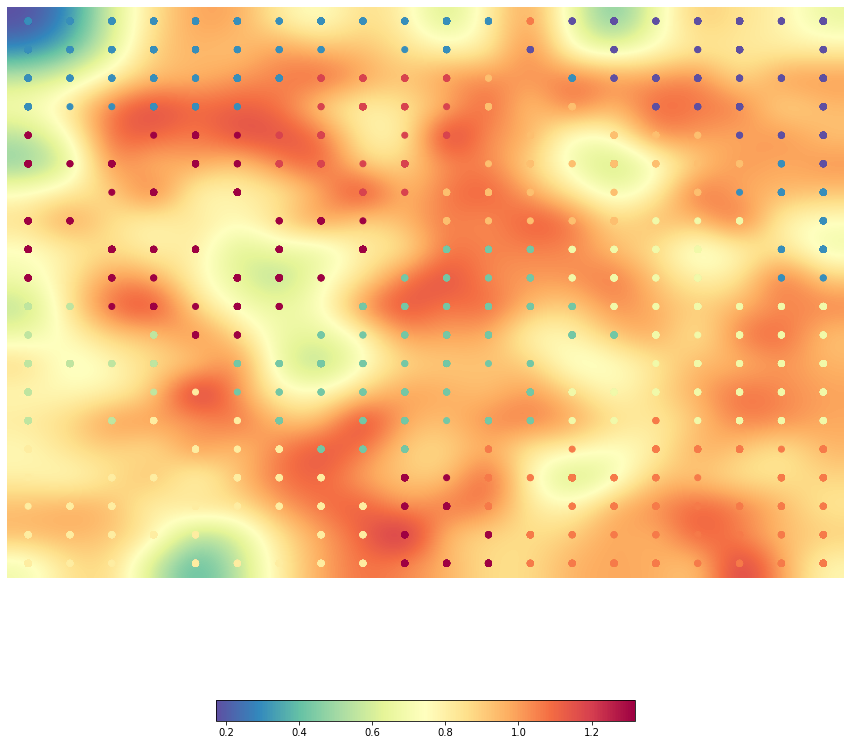


 For 20X20 Grid and k = 10 our clusters are 

[[1 1 1 1 1 1 1 1 1 1 1 1 7 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 8 8 8 8 6 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 8 8 8 8 6 6 6 6 0 0 0 0 0]
 [9 9 9 9 9 9 8 8 8 8 8 6 6 6 6 6 6 0 0 0]
 [9 9 9 9 9 9 8 8 8 8 8 6 6 6 6 6 6 6 1 0]
 [9 9 9 9 9 9 9 8 8 8 6 6 6 6 6 6 6 1 1 1]
 [9 9 9 9 9 9 9 9 9 9 6 6 6 6 6 4 4 4 1 1]
 [9 9 9 9 9 9 9 9 9 9 2 2 2 4 4 4 4 4 1 1]
 [9 9 9 9 9 9 9 9 9 2 2 2 2 4 4 4 4 4 1 1]
 [3 3 9 9 9 9 9 2 2 2 2 2 2 2 4 4 4 4 4 4]
 [3 3 3 3 9 9 2 2 2 2 2 2 2 2 2 4 4 4 4 4]
 [3 3 3 3 9 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4]
 [3 3 3 3 5 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4]
 [3 3 3 5 5 5 2 2 2 2 2 2 2 4 4 7 4 4 4 4]
 [5 5 5 5 5 5 5 2 2 2 2 7 7 7 7 7 7 7 7 7]
 [5 5 5 5 5 5 5 5 9 9 9 7 7 7 7 7 7 7 7 7]
 [5 5 5 5 5 5 5 5 5 9 9 7 7 7 7 7 7 7 7 7]
 [5 5 5 5 5 5 5 5 5 9 9 9 7 7 7 7 7 7 7 7]
 [5 5 5 5 5 5 5 5 5 9 9 9 7 7 7 7 7 7 7 7]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons


In [ ]:
k = 10
show_result("20X20", k, som_20_full, (15, 15))

### **Δοκιμάζουμε 20Χ20 Grid και k=20**.

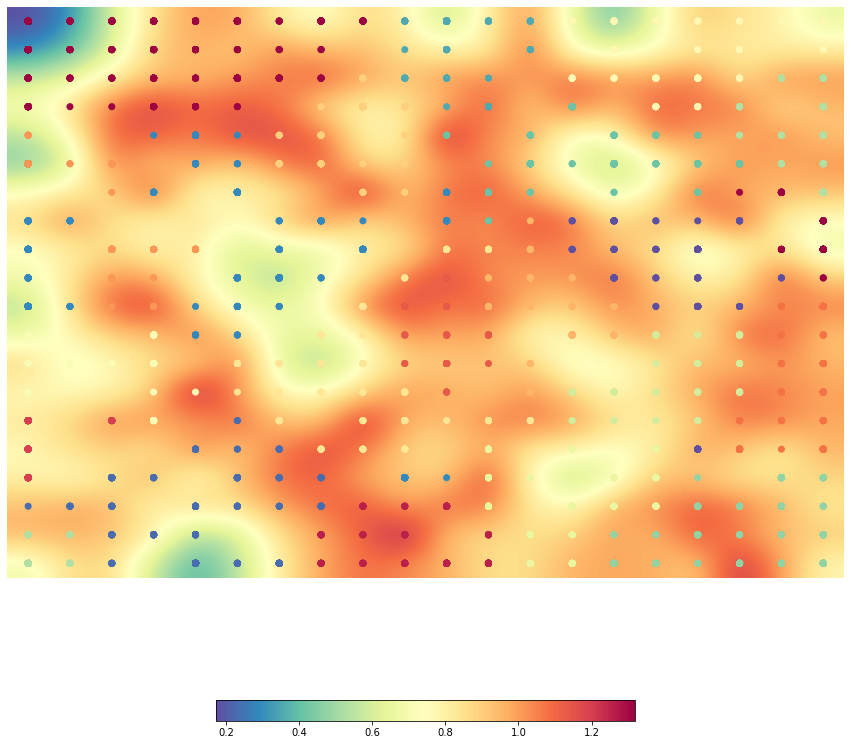


 For 20X20 Grid and k = 20 our clusters are 

[[19 19 19 19 19 19 19 19 19  3  3  3  3 10 10 10 10 10 10 10]
 [19 19 19 19 19 19 19 19 19  3  3  3  3 10 10 10 10 10 10 10]
 [19 19 19 19 19 19 19 19 12  3  3  3  3 10 10 10 10 10  6  6]
 [19 19 19 19 19 19 19 12 12 12  3  3  4  4  4 10 10  6  6  6]
 [14 14 14  2  2  2 12 12 12 12  4  4  4  4  4  4  4  6  6  6]
 [14 14 14 14  2  2 12 12 12 12 12  4  4  4  4  4  4  4  6  6]
 [14 14 14  2  2  2  2 12 12 12  2  4  4  4  4  4  4 19 19  6]
 [ 2  2 14 14 14  2  2  2  2  2  2  4 13  0  0  0  0  0 19 19]
 [ 2  2 14 14 14  2  2  2  2  2 11 11 13  0  0  0  0  0 19 19]
 [ 2  2 14 14  2  2  2  2  2 11 16 13 13 13  0  0  0  0  0 19]
 [ 2  2 14 14  2  2  2 11 11 16 16 13 13 13 13  0  0  0 15 15]
 [ 9  9  9  9  2  2 11 11 11 16 16 16 13 13 13  7  7  7 15 15]
 [ 9  9  9  9  9 11 11 11 11 16 16 16 13 13  7  7  7  7 15 15]
 [ 9  9  9  9  9 11 11 11 11 11 16 11 13  7  7  7  7  7 15 15]
 [17 17 17  9  1  1 11 11 11 11 11 11 11  7  7  7  7 15 15 15]
 [17 17 

In [ ]:
k = 20
show_result("20X20", k, som_20_full, (15, 15))

### **Δοκιμάζουμε 20Χ20 Grid και k=25**.

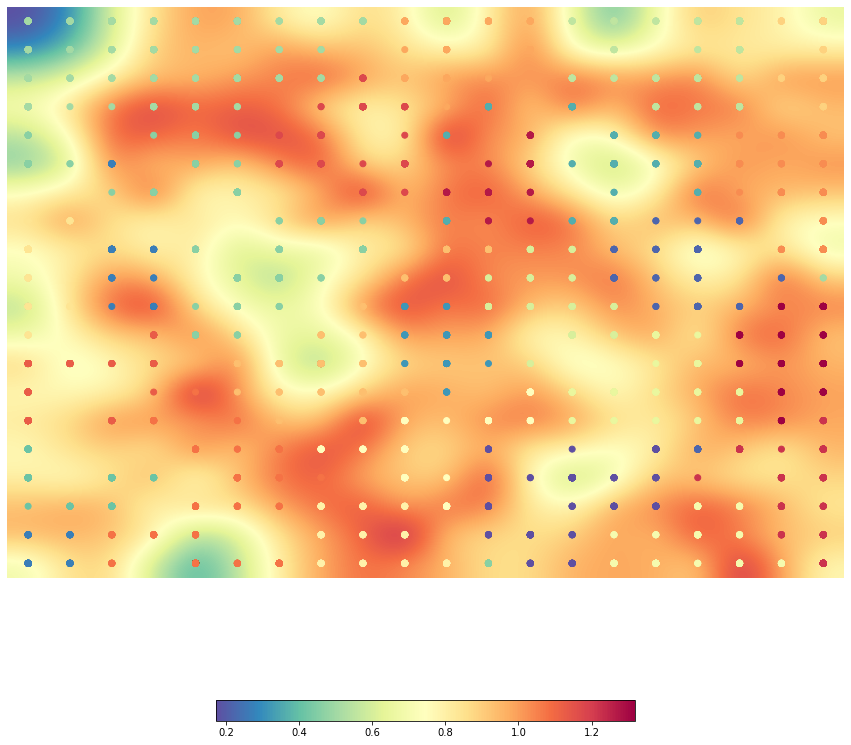


 For 20X20 Grid and k = 25 our clusters are 

[[ 7  7  7  7  7  7  7  7  7 17 17 17 17  8  8  8  8  8 15 15]
 [ 7  7  7  7  7  7  7  7  7 17 17 17 17  8  8  8  8  8 15 15]
 [ 7  7  7  7  7  7  7  7 21 17 17 17  8  8  8  8  8  8 15 15]
 [ 7  7  7  7  7  7  7 21 21 21 17  4  4  4  4  8  8  8 15 15]
 [ 6  6  2  6  6  6 21 21 21 21  4  4 23  4  4  4  4 18 18 18]
 [ 6  6  2  6  6  6 21 21 21 21 21 23 23  4  4  4  4 18 18 18]
 [ 6  6  6  6  6  6  6 21 21 21 23 23 23  4  4  4  4 18 18 18]
 [14 14  2  6  6  6  6  6  6  6  4 23 23  4  4  1  1  1 18 18]
 [14 14  2  2  6  6  6  6  6  6 16 16  9  9  1  1  1  1 18 18]
 [14 14  2  2  6  6  6  6  6 16 16  9  9  9  1  1  1  1  1  7]
 [14 14  2  2  6  6  6 16 16  3  3  9  9  9  9  1  1  1 24 24]
 [14 20 20 20  6  6 16 16 16  3  3  3  9  9  9 10 10 24 24 24]
 [20 20 20 20  6 16 16 16 16  3  3  3  9  9 10 10 10 24 24 24]
 [20 20 20 20 19 16 16 16 16 16  3 12 12 10 10 10 10 10 24 24]
 [20 20 20 19 19 19 16 16 16 12 12 12 12 10 10 10 10 10 24 22]
 [ 5  5 

In [ ]:
k = 25
show_result("20X20", k, som_20_full, (15, 15))

### **Σχολιασμός για το Grid 20X20**

#### Αυξάνοντας τους νευρώνες σε 20Χ20 παρατήρουμε ίδια κατάσταση με τα αποτελέσματα που είχαμε για 15Χ15. Οφείλουμε να τονίσουμε πως για k=25 είχαμε καλύτερο χάρτη σε grid 15X15 συγκριτικά με το χάρτη που πήραμε σε grid 20X20. Αυτό υποδεικνύει πως ένα μεγαλύτερο grid δε θα φέρει απαραίτητα καλύτερα αποτελέσματα.

#### Συνεπώς συνεχίζουμε την οπτική βελτίωση για μεγαλύτερο Grid.

### **Δοκιμάζουμε 25Χ25 Grid και k=10**.

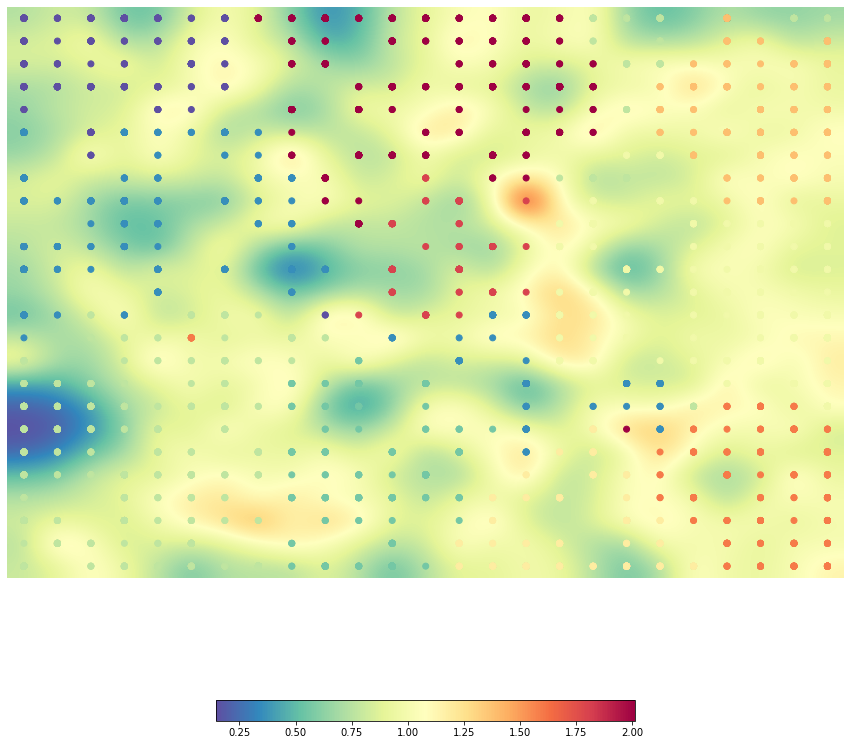


 For 25X25 Grid and k = 10 our clusters are 

[[0 0 0 0 0 0 0 9 9 9 9 9 9 9 9 9 9 3 3 3 6 6 6 3 3]
 [0 0 0 0 0 0 0 9 9 9 9 9 9 9 9 9 9 3 3 3 6 6 6 6 6]
 [0 0 0 0 0 0 0 9 9 9 9 9 9 9 9 9 9 9 3 3 6 6 6 6 6]
 [0 0 0 0 0 0 0 0 9 9 9 9 9 9 9 9 9 9 3 6 6 6 6 6 6]
 [0 0 0 0 0 0 1 9 9 9 9 9 9 9 9 9 9 9 3 6 6 6 6 6 6]
 [1 1 0 1 1 1 1 1 9 9 9 9 9 9 9 9 9 9 3 6 6 6 6 6 6]
 [1 1 0 1 1 1 1 1 9 9 9 9 9 9 9 9 9 3 4 4 6 6 6 6 6]
 [1 1 1 1 1 1 1 1 1 9 9 9 8 8 9 9 3 3 3 4 6 6 6 6 6]
 [1 1 1 1 1 1 1 1 1 9 9 8 8 8 8 8 4 4 4 4 4 6 6 6 6]
 [1 1 1 1 1 1 1 1 1 9 9 8 8 8 8 8 4 4 4 4 4 4 4 4 4]
 [1 1 1 1 1 1 1 1 1 1 8 8 8 8 8 8 4 4 4 4 4 4 4 4 4]
 [1 1 1 1 1 1 1 1 1 1 8 8 8 8 8 8 4 4 4 4 4 4 4 4 4]
 [1 1 1 1 1 1 1 1 1 1 8 8 8 8 8 8 4 4 4 4 4 4 4 4 4]
 [1 1 3 1 1 3 3 3 1 0 8 8 8 8 1 1 4 4 4 4 4 4 4 4 4]
 [1 3 3 3 3 7 3 3 3 3 1 1 8 1 1 1 4 4 4 4 4 4 4 4 4]
 [3 3 3 3 3 3 3 3 3 3 2 2 2 1 1 1 4 4 1 4 4 4 4 4 4]
 [3 3 3 3 3 3 3 3 2 2 2 2 2 2 1 1 1 1 1 1 4 4 4 4 4]
 [3 3 3 3 3 3 3 3 2 2 2 2 2 2 1 1 1 1 1 1 3 7 7 7 4]

In [ ]:
k = 10
show_result("25X25", k, som_25_full, (15, 15))

### **Δοκιμάζουμε 25Χ25 Grid και k=20**.

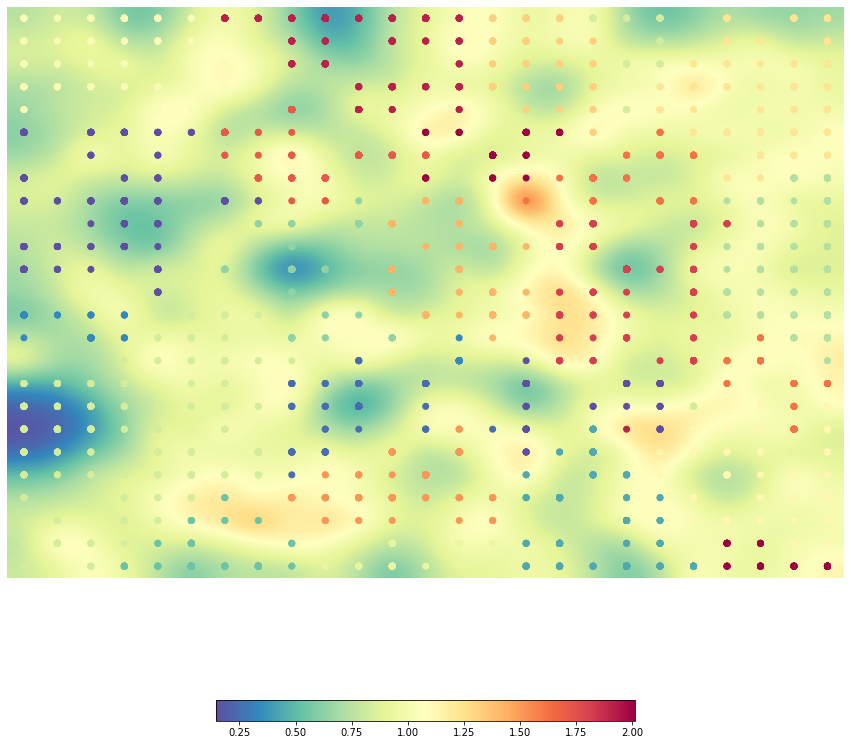


 For 25X25 Grid and k = 20 our clusters are 

[[ 9  9  9  9  9  9 18 18 18 18 18 18 18 18 12 12 12  7  7  7 11 11 11 11
  11]
 [ 9  9  9  9  9  9  9 18 18 18 18 18 18 18 12 12 12 12  7  7 11 11 11 11
  11]
 [ 9  9  9  9  9  9  9 18 18 18 18 18 18 18 12 12 12 12  7  7 11 11 11 11
  11]
 [ 9  9  9  9  9  9  9 16 16 18 18 18 18 18 12 12 12 12  7 11 11 11 11 11
  11]
 [ 9  9  9  9  9  9 16 16 16 16 18 18 18 18 12 12 12 12  7 11 11 11 11 11
  11]
 [ 0  0  0  0  0  0 16 16 16 16 16 16 19 19 19 19 19 12 15 15 11 11 11 11
  11]
 [ 0  0  0  0  0  0 16 16 16 16 16 16 16 19 19 19 19 15 15 15 15 11 11 11
  11]
 [ 0  0  0  0  0  0  0 16 16 16 16 16 19 13 19 19 15 15 15 15 15 11 11  6
   6]
 [ 0  0  0  0  0  0  0  0 16 16  5 13 13 13 13 15 15 15 15 15 15  6  6  6
   6]
 [ 0  0  0  0  0  0  0  5  5  5  5 13 13 13 13 13 17 17 17 17 17 17  6  6
   6]
 [ 0  0  0  0  0  0  5  5  5  5  5 13 13 13 13 13 17 17 17 17 17  6  6  6
   6]
 [ 0  0  0  0  0  0  5  5  5  5  5 13 13 13 13 13 17 17 17 17 17  6  6  6

In [ ]:
k = 20
show_result("25X25", k, som_25_full, (15, 15))

### **Δοκιμάζουμε 25Χ25 Grid και k=25**.

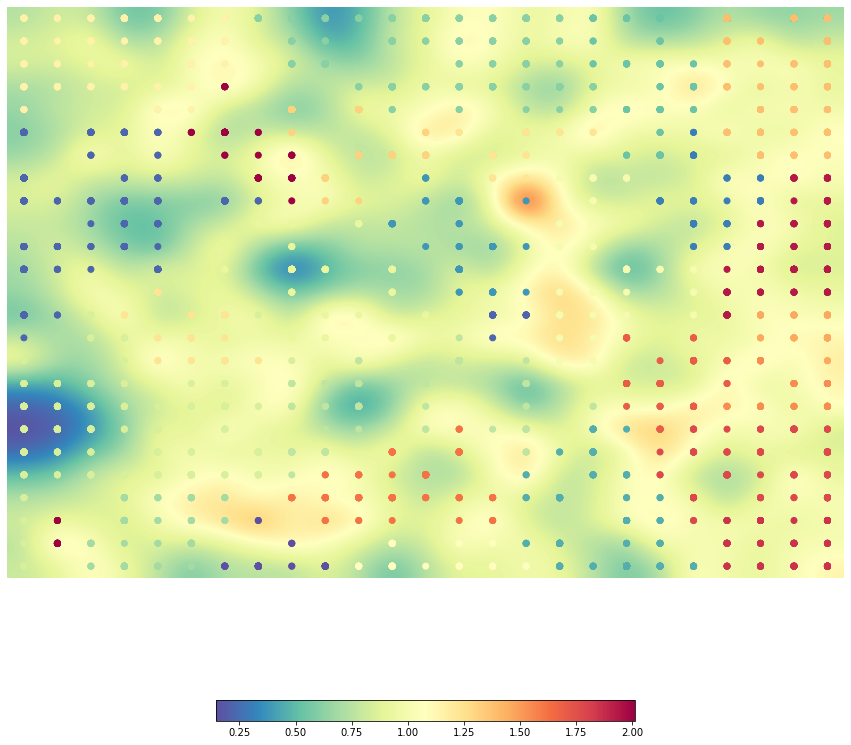


 For 25X25 Grid and k = 25 our clusters are 

[[13 13 13 13 13 13 13  6  6  6  6  6  6  6  6  6  6  5  5  5  5 16 16 16
  16]
 [13 13 13 13 13 13 13  6  6  6  6  6  6  6  6  6  6  5  5  5  5 16 16 16
  16]
 [13 13 13 13 13 13 13  6  6  6  6  6  6  6  6  6  6  5  5  5  5 16 16 16
  16]
 [13 13 13 13 13 13 24 24 15  6  6  6  6  6  6  6  6  6  5  5  5 16 16 16
  16]
 [13 13 13 13 13 13 24 15 15 15 15  6  6  6  6  6  6  6  5  5  5 16 16 16
  16]
 [ 1  1  1  1  1 24 24 24 15 15 15 15 15 14 14 14 14 14  5  5  2 16 16 16
  16]
 [ 1  1  1  1  1 24 24 24 24 15 15 15 15 14 14 14 14 11  5  5  2 16 16 16
  16]
 [ 1  1  1  1  1  1  1 24 24 15 15 15  3  3 14 14 11 11 11  2  2  2  2 23
  23]
 [ 1  1  1  1  1  1  1  1 24 15 15  3  3  3  3  3 11 11  2  2  2  2  2 23
  23]
 [ 1  1  1  1  1  1  1 10 10 10 10  3  3  3  3  3 11 11 11  2  2  2 23 23
  23]
 [ 1  1  1  1  1  1 10 10 10 10 10 10  3  3  3  3 11 11 11 11  2  2 23 23
  23]
 [ 1  1  1  1  1  1 10 10 10 10 10 10  3  3  3  3 11 11 11 11 11 23 23 23

In [ ]:
k = 25
show_result("25X25", k, som_25_full, (15, 15))

### **Σχολιασμός για το Grid 25X25**

### Αυτό το οποίο παρατηρούμε σε αυτή την περίπτωση είναι πως έχουμε αρκετές μπλε-πράσινες περιοχές. Επίσης οι κόκκινες περιοχές απουσιάζουν και στη θέση τους έχουμε κίτρινες περιοχές, αυτό σημαίνει πως η απόσταση ανάμεσα στους νευρώνες έχει ελαττωθεί και ουσιαστικά τα σύνορα ανάμεσα στα clusters έχουν μεσαία απόσταση. Ωστόσο γνωρίζουμε πως κάποια clusters αναγκαστικά θα συνορεύσουν και θα διαφέρουν μεταξύ τους, οπότε θα έχουμε και κόκκινες περιοχές. Αυτό που ζητάμε είναι ιδανικά να έχουμε λίγες κόκκινες περιοχές που να διαφοροποιούνται τα clusters. To να έχουμε μόνο πράσινες περιοχές δεν ακούγεται ιδανικό καθώς αυτό σημαίνει πως τα clusters δε διαφέρουν μεταξύ τους, κάτι το οποίο δεν ισχύει.

### Ωστόσο θα δούμε τα αποτελέσματα και για μεγαλύτερο grid στην προσπάθεια να βελτιστοποιήσουμε το U-matrix ακόμα περισσότερο.

### **Δοκιμάζουμε 30Χ30 Grid και k=10**.

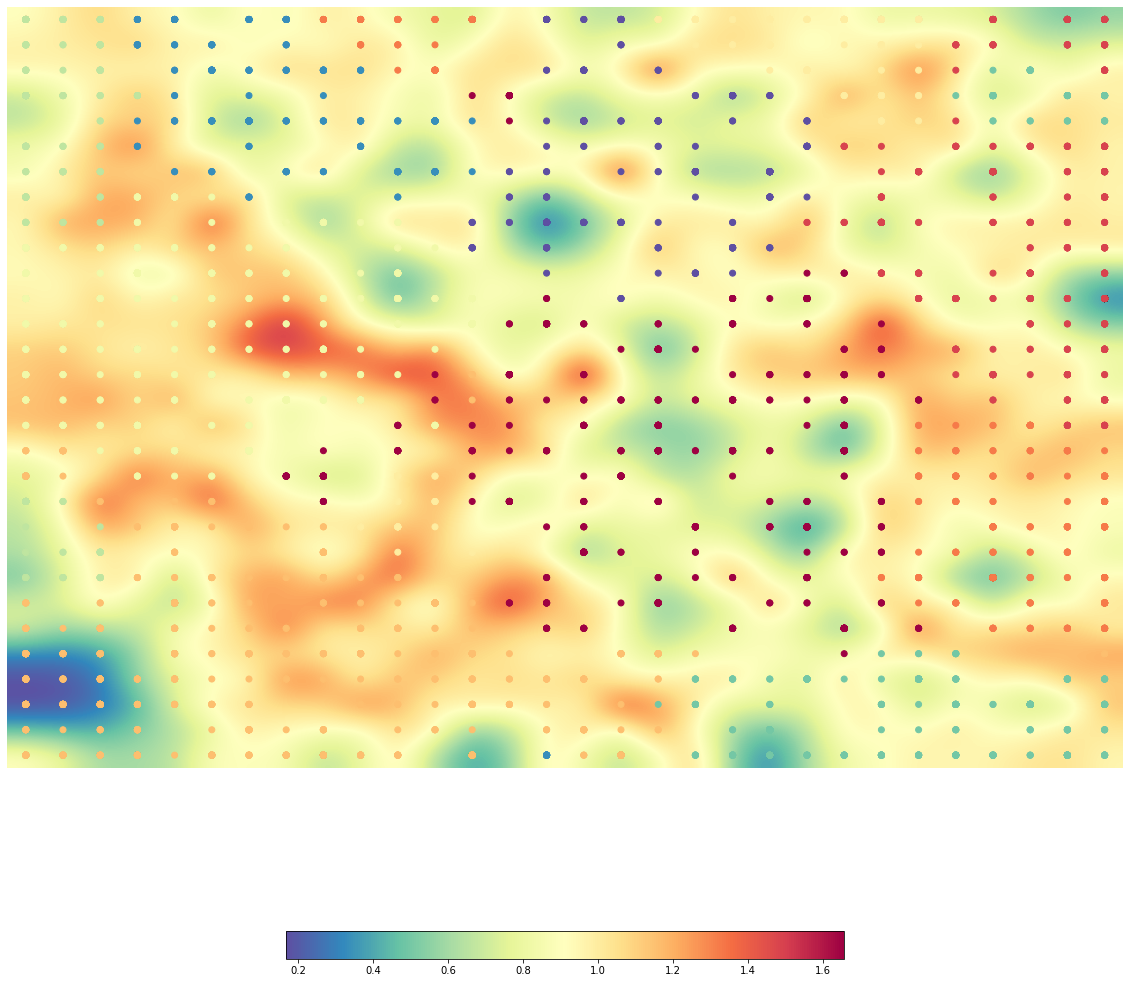


 For 30X30 Grid and k = 10 our clusters are 

[[3 3 3 1 1 1 1 1 7 7 7 7 7 7 0 0 0 5 5 5 5 5 5 5 5 8 8 8 8 8]
 [3 3 3 1 1 1 1 1 1 7 7 7 7 7 0 0 0 5 5 5 5 5 5 5 5 8 8 8 8 8]
 [3 3 3 1 1 1 1 1 1 1 7 7 7 9 0 0 0 0 5 0 5 5 5 5 5 8 2 2 8 8]
 [3 3 3 3 1 1 1 1 1 1 1 1 9 9 9 0 0 0 0 0 0 5 5 5 5 2 2 2 2 2]
 [3 3 3 1 1 1 1 1 1 1 1 1 1 9 0 0 0 0 0 0 0 0 5 5 5 8 2 2 2 2]
 [3 3 3 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8]
 [3 3 3 4 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8]
 [3 3 3 4 4 4 1 1 1 1 1 1 9 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8]
 [3 3 3 4 4 4 4 4 4 4 4 9 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8 8]
 [4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8 8]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 9 9 8 8 8 8 8 8 8]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 0 0 0 9 9 9 9 8 8 8 8 8 8 8]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 8 8 8 8 8 8]
 [4 4 4 4 4 4 4 4 4 4 4 4 4 9 9 9 9 9 9 9 9 9 9 9 8 8 8 8 8 8]
 [4 4 4 4 4 4 4 4 4 4 4 9 6 9 9 9 9 9 9 9 9 9 9 9 9 8 8 8 8 8]
 [4 4 4 

In [ ]:
k = 10
show_result("30X30", k, som_30_full, (20, 20))

### **Δοκιμάζουμε 30Χ30 Grid και k=20**.

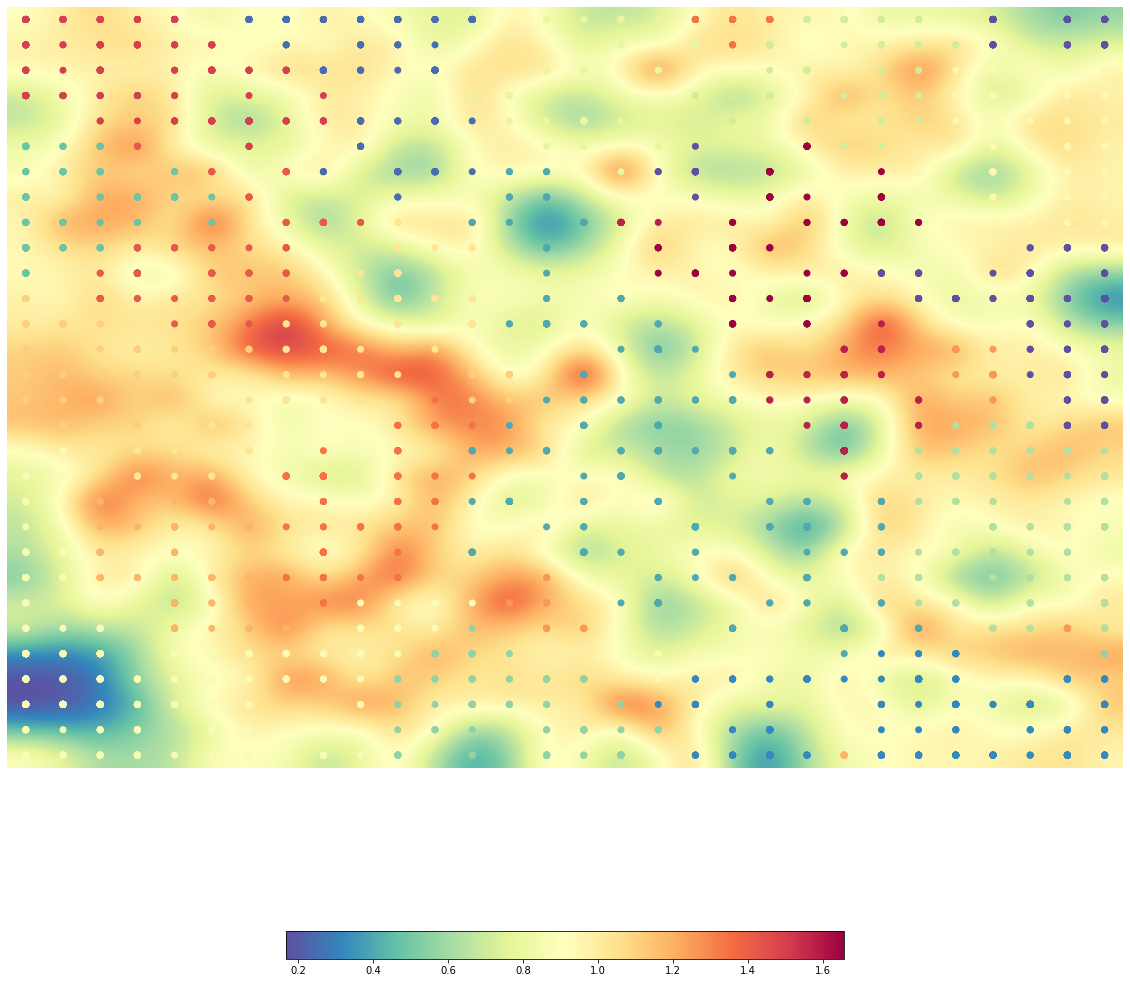


 For 30X30 Grid and k = 20 our clusters are 

[[17 17 17 17 17 17  1  1  1  1  1  1  1  8  8  8  8  8 15 15 15  7  7  7
   7  0  0  0  0  0]
 [17 17 17 17 17 17 17  1  1  1  1  1  1  8  8  8  8  8  8 15  7  7  7  7
   7  7  0  0  0  0]
 [17 17 17 17 17 17 17 17  1  1  1  1  1  8  8  8  8  8  8  7  7  7  7  7
   7 10 10 10 10 10]
 [17 17 17 17 17 17 17 17 17  1  1  1  8  8  8  8  8  8  7  7  7  7  7  7
   7 10 10 10 10 10]
 [17 17 17 17 17 17 17 17 17  1  1  1  1  8  8  8  8  8  8  7  7  7  7  7
   7 10 10 10 10 10]
 [ 4  4  4 16 17 17 17 17  1  1  1  1  1  8  8  8  8  8  0 19 19 19  7  7
  10 10 10 10 10 10]
 [ 4  4  4  4  4 16 16 16  1  1  1  1  1  3  3  8  8  0  0 19 19 19 19 19
  10 10 10 10 10 10]
 [ 4  4  4  4  4  4 16 16 16 16  1  1  3  3  3  3 18  0  0 19 19 19 19 19
  19 10 10 10 10 10]
 [ 4  4  4  4  4  4 16 16 16 16 11  3  3  3  3  3 18 18 19 19 19 19 19 19
  19 10 10 10 10 10]
 [ 4  4  4 16 16 16 16 16 16 11 11 11 11  3  3  3 18 19 19 19 19 19 19 19
   0  0  0  0  0  0]
 [ 

In [ ]:
k = 20
show_result("30X30", k, som_30_full, (20, 20))

### **Δοκιμάζουμε 30Χ30 Grid και k=25**.

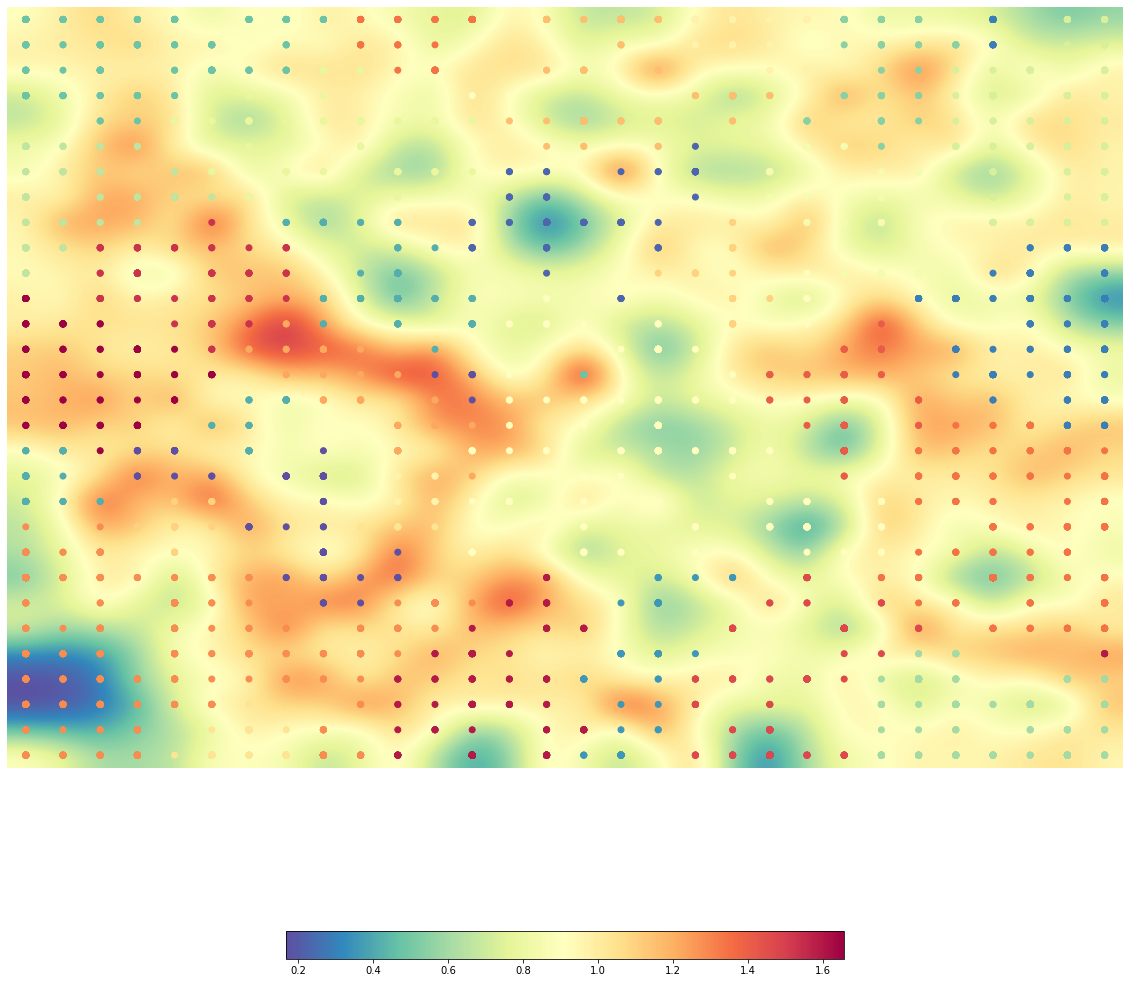


 For 30X30 Grid and k = 25 our clusters are 

[[ 5  5  5  5  5  5  5  5  5 19 19 19 19 19 16 16 16 16 13 13 13 13  6  6
   6  2  2  9  9  9]
 [ 5  5  5  5  5  5  5  5 10 19 19 19 19 19 16 16 16 16 13 13 13 13  6  6
   6  6  2  9  9  9]
 [ 5  5  5  5  5  5  5  5 10 10 19 19 19 16 16 16 16 16 16 16 13 13  6  6
   6  9  9  9  9  9]
 [ 5  5  5  5  5 10 10 10 10 10 10 10 12 12 16 16 16 16 16 16 16  6  6  6
   6  9  9  9  9  9]
 [ 5  5  5  5 10 10 10 10 10 10 10 10 10 16 16 16 16 16 16 16 16  6  6  6
   6  9  9  9  9  9]
 [ 8  8  8  8 10 10 10 10 10 10 10 10 10  1 16 16 16 16  1 11 11 11 11  6
   9  9  9  9  9  9]
 [ 8  8  8  8  8 10 10 10 10 10 10 10 10  1  1  1  1  1  1 11 11 11 11 11
  11  9  9  9  9  9]
 [ 8  8  8  8  8  8 10 10 10 10 10 10  1  1  1  1  1  1  1 11 11 11 11 11
  11  9  9  9  9  9]
 [ 8  8  8  8  8 22 22  4  4  4  4  4  1  1  1  1  1  1 15 15 11 11 11 11
  11  2  9  9  9  9]
 [ 8  8 22 22 22 22 22 22  4  4  4  4  1  1  1  1  1  1 15 15 15 11 11 11
  11 11  2  2  2  2]
 [ 

In [ ]:
k = 25
show_result("30X30", k, som_30_full, (20, 20))

### **Σχολιασμός για το Grid 30X30**

### Τα καλύτερα αποτέλεσματα σε αυτές τις διαστάσεις τα παίρνουμε οπτικά για k=25. Αν και δεν απεικονίζεται, δοκιμάστηκαν και μεγαλύτερα k τα οποία όμως δεν οδήγησαν σε ορατή βελτιστοποίηση. Ωστόσο για k=25 έχουμε ένα καλό χάρτη όπου στις πολύ έντονες κόκκινες περιοχές παρατηρούμε διαφορετικά clusters, δηλαδή στα σημεία όπου οι νευρώνες έχουν μεγάλη απόσταση μεταξύ τους, πράγματι έχουμε διαφορές στις κατηγορίες των ταινιών. Αυτός είναι οι διαστάσεις που θα αξιολογήσουμε σημασιολογικά παρακάτω.


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [ ]:
def print_categories_stats(movies_ids, number=None):
  total_categories = []
  for movie in movies_ids:
    movie_categories = categories[movie][0].split(",  ")
    for category in movie_categories:
      extracted_categories = []
      extracted_categories.append(category[1:len(category) - 1])
    total_categories.extend(extracted_categories)
  unique_categories, counts_unique_categories = np.unique(total_categories, return_counts = True)
  dictionary = {}
  # initialize dictionary
  dictionary = dict(zip(unique_categories, counts_unique_categories.flatten()))
  # sort dictionary
  dictionary = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))
  mydataframe = []
  for key,value in dictionary.items():
    #append category, count, percentage
    mydataframe.append((key, value, value/len(movies_ids)))
  #print(mydataframe)
  set_categories = set(zip(unique_categories, counts_unique_categories))
  # sort the set
  set_categories = sorted(set_categories, key=lambda x:x[1], reverse=True)
  # return a dataframe for visual purposes
  if number+1:
    # display only first 10 rows
    df = pd.DataFrame(mydataframe, columns =['Categories','Frequency', 'Percentage']).head(10).style.set_properties(**{'text-align': 'left'}).set_caption(
        f'Cluster {number}').hide_index().set_table_styles(
            [{'selector': 'th', 'props': [('text-align', 'left')]},
             {'selector': 'caption', 'props': [('color', '#ff0366'), ('font-size', '22px'), ('font-weight', 'bold'), ('text-align', 'left')]},
             {'selector': 'th.col_heading', 'props': [('color', '#ffffff '), ('font-size', '12px'), ('font-weight', 'bold')]}])
    display(df)
    return
  else:
    df = pd.DataFrame(mydataframe, columns =['Categories','Frequency', 'Percentage']).head(10).style.hide_index()
    # display only first 10 rows
    display(df)

In [ ]:
# test our print_categories_stats for all movies
# curious to see our total category stats
all_movies = [x for x in range(5000)]
print_categories_stats(all_movies, -1)

In [ ]:
def print_cluster_neurons_movies_report(cluster_id):
  # extract clusters_id from clusters
  raw_coords = np.where(clusters == cluster_id)
  #print(raw_coords)
  # create a list of tuples
  two_dimension_coords = list(zip(raw_coords[0], raw_coords[1]))
  #print(two_dimension_coords)
  ids_of_cluster = []
  for i in two_dimension_coords:
    for elem in range(len(ubmus_30_full)):
      if i[0] == ubmus_30_full[elem][0] and i[1] == ubmus_30_full[elem][1]:
        ids_of_cluster.append(elem)
  #print(ids_of_cluster)
  movie_ids = neuron_movies_report(ids_of_cluster)
  print_categories_stats(movie_ids, cluster_id)

In [ ]:
def neuron_movies_report(cluster_ids):
  movie_ids = []
  for id in cluster_ids:
    # take first element of the tuple
    specific_movie_id = np.where(indices_30_full == id)[0]
    # and to the returned list
    movie_ids.extend(specific_movie_id)
  return movie_ids

### Έχουμε ορίσει τις 3 συναρτήσεις, πλέον θα τυπώσουμε τον τελικό χάρτη με Grid 30X30 και k=25. Αυτές τις διαστάσεις νωρίτερα τις ορίσαμε ως καλές συγκριτικά με τις άλλες προσπάθειες μας. Στον παρακάτω χάρτη θα πραγματοποιηθεί η σημασιολογική ανάλυση.

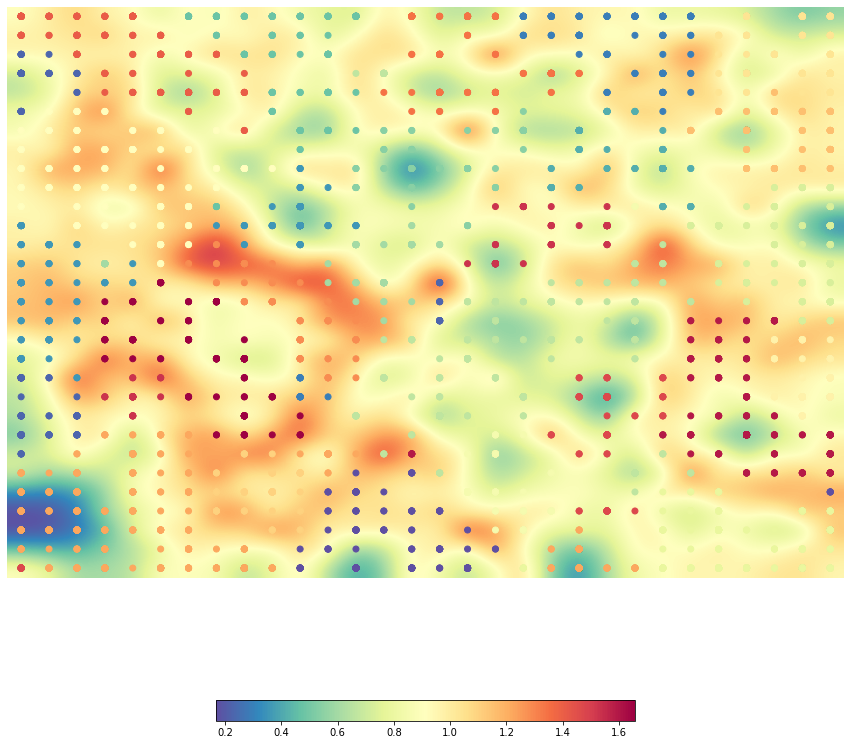


Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons


In [ ]:
### 30Χ30 GRID, k=25
import seaborn as sns
cm = sns.color_palette("rocket", as_cmap=True)

k = 25
algorithm = KMeans(n_clusters = k)
som_30_full.cluster(algorithm=algorithm)
som_30_full.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))
clusters = som_30_full.clusters
# display clusters with more visual tools this time
print()
index =[]
for i in range(30):
  index.append(f'Cluster {i}')
df = pd.DataFrame(clusters, index).style.set_caption('Clusters For 30X30 Grid and k = 25').background_gradient(cmap=cm, axis=None).set_table_styles(
      [{'selector': 'th', 'props': [('text-align', 'center')]}, 
       {'selector': 'caption', 'props': [('color', '#ff0366'), ('font-size', '22px'), ('font-weight', 'bold'), ('text-align', 'center')]},
       {'selector': 'th.col_heading', 'props': [('color', '#ffffff '), ('font-size', '12px'), ('font-weight', 'bold'), ('text-align', 'center')]}])
display(df)
values, counts = np.unique(clusters, return_counts=True)
print("\nCluster sorted by increasing number of neurons:")
print("Cluster index")
print("Number of neurons")  
dict_display = {}
# i actually is the values
for i in range(len(counts)):
  dict_display[i] = counts[i].flatten()
df1 = pd.DataFrame(dict_display).style.hide_index()
display(df1)

In [ ]:
# print top10 categories that exist in every k
for i in range(0, k):
  print_cluster_neurons_movies_report(i)
  print()

#  **Ανάλυση τοπολογικών ιδιοτήτων του παραπάνω χάρτη.**

### Όπως έχει αναφερθεί και νωρίτερα ο χάρτης μας περιέχει αρκετές μπλε-πράσινες περιοχές και ελάχιστες κόκκινες περιοχές. Για την ακρίβεια διαπιστώνουμε πως έχουμε 3 κόκκινες περιοχές στις οποίες οι νευρώνες μας διαφοροποιούνται. Αυτή τη διαφοροποίηση μπορούμε να την παρατηρήσουμε τόσο από το χάρτη όσο και από το χρωματισμένο dataframe που απεικονίζει κάθε cluster και σε διαφορετικό χρώμα. Για παράδειγμα οπτικά από το χάρτη βλέπουμε μία έντονη κόκκινη περιοχή κοντά στην περιοχή (13,8). Πρόκειται για την πιο έντονη κόκκινη περιοχή λίγο αριστερά από τη μέση του χάρτη. Από το χρωματισμένο dataframe παρατηρούμε πως σε εκείνο το σημείο έχουμε διαφορετικά clusters, για την ακρίβεια εμπλέκονται τα clusters 3, 5, 12 και 18. Κοινώς επιβεβαιώνουμε τα οπτικά αποτελέσματα του χάρτη και από το χρωματισμένο dataframe.

### Γενικότερα οι κατηγορίες στα clusters μας δείχνουν να έχουν μια συνάφεια καθώς η κορυφαία κατηγορία σε κάθε cluster είναι σχεδόν διπλάσια από τη δεύτερη κατηγορία και ύστερα οι υπόλοιπες κατηγορίες είναι πολύ μικρότερες σε ποσοστό συγκριτικά με τη 2η κατηγορία. Φαίνεται, δηλαδή πως ένα cluster χαρακτηρίζεται αρκετά από την κορυφαία κατηγορία και οι υπόλοιπες κατηγορίες έρχονται να συμπληρώσουν την κορυφαία κατηγορία. Για παράδειγμα το cluster 2 έχει ως κορυφαία κατηγορία το Comedy και η δεύτερη κατηγορία είναι το slapstick, το οποίο αποτελεί ένα ακόμα είδος Comedy. Ένα ακόμα παραδείγμα αποτελεί το cluster 16 το οποίο έχει κορυφαία κατηγορία το Action και δεύτερη κορυφαία κατηγορία το Crime Thriller. Προφανώς το cluster 16 έχει ταινίες με περιπέτεια που περιλαμβάνουν στοιχεία θρίλερ. Χαρακτηριστικό παράδειγμα αποτελεί και το cluster 24 το οποίο περιλαμβάνει ως κορυφαία κατηγορία το Documentary και ως δεύτερη κατηγορία το Silent Film το οποίο σχετίζεται με το Documentary. Αντίστοιχα ισχύουν και για τα περισσότερα clusters έκτος από κάποιες εξαιρέσεις τις οποίες θα αναλύσουμε παρακάτω.

### Πλέον παρατηρούμε τις κατηγορίες που εμπλέκονται σε κάθε ενα cluster από τα 25 διαθέσιμα. Αρχικά εκτυπώνουμε πάλι την κατανομή των τοπ 10 κατηγοριών των 5.000 ταινιών.

In [ ]:
print_categories_stats(all_movies, -1)

### Παρατηρούμε πως από τις 5000 ταινίες οι 738 είναι κατηγορίας Δράμα και 485 ταινίες είναι Κωμωδία. Εδώ έχουμε δεδομένα που έχουν μεγάλη πυκνότητα πιθανότητας στο χώρο εισόδου. 

### Μάλιστα από τα 25 clusters έχουμε αρκετά που περιλαμβάνουν ως κορυφαία κατηγορία το Comedy. Αυτά είναι το cluster 0, 2 και 11. Μάλιστα τα clusters 0 και 11 έχουν κοινές τις δύο πρώτες κατηγορίες και βρίσκονται κοντά μεταξύ τους όπως παρατηρούμε στο dataframe μας. Το cluster 2 βρίσκεται μακριά από τα προηγούμενα δύο clusters διότι παρατηρώντας τις κατηγορίες του αντιλαμβανόμαστε πως περιέχει διαφορετικό είδος κωμωδίας. Κοινώς η κατηγορία Κωμωδία απεικονίζεται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. 

### Αντίστοιχα τα clusters 12, 15, 18, 20 και 23 περιλαμβάνουν ως κορυφαία κατηγορία το Drama. Συγκεκριμένα τα clusters 12, 18 και 20 βρίσκονται σε πολύ κοντινή απόσταση και απομακρυσμένα από τα 15 και 23. Μάλιστα τα clusters 15 και 23 είναι και αυτά σε μακρινή απόσταση. Αξιοσημείωτο αποτελεί εδώ πως τα clusters 12 και 20 σχηματίζουν πράσινη περιοχή και αυτό δικαιολογείται από τις κοινές κατηγορίες που έχουν. Ωστόσο τα clusters 12 και 18 ανήκουν στην έντονη κόκκινη περιοχή διότι από τις κατηγορίες του cluster 18 παρατηρούμε πως περιλαμβάνει ασπόμαυρες ταινίες οι οποίες απουσιάζουν από το cluster 12. Aυτή η διαφορά στην κατηγορία Black-and-White οριοθετεί την μεγάλη απόσταση ανάμεσα στα clusters και συνεπώς το κόκκινο χρώμα.

###  Λιγότερο συχνές ταινίες είναι εκείνες με την κατηγορία Western. Το cluster 9 περιλαμβάνει αυτή την κατηγορία και εντοπίζεται δεξιά στο χάρτη μας. Μάλιστα το cluster 9 καταλαμβάνει μόνο του μια πράσινη περιοχή αλλά συνορεύει με τα γειτονικά cluster με κίτρινη περιοχή, αυτό διότι τα γειτονικά clusters δεν έχουν την κατηγορία western. Μια ακόμη λιγότερη συχνή κατηγορία είναι το Japanese Movies το οποίο εντοπίσαμε στο cluster 13 που εντοπίζεται δεξιά στο χάρτη σε ελαφρώς κίτρινη περιοχή καθώς συνορεύει με το cluster 9 που μόλις αναλύσαμε.

### Όσον αφορά τα μακρινά πρότυπα εισόδου ήδη έχουμε παραθέσει κάποια συμπεράσματα. Γενικότερα κοινές κατηγορίες ανάμεσα στα clusters θα έχει ως αποτέλεσμα να εντοπίσουμε τα clusters κοντά στο χάρτη όπως έγινε με τα clusters 0 και 11. Μια διαφοροποίηση όμως στις κατηγορίες είναι αρκετή να απομακρύνει τα clusters ή να δημιουργήσει ένα σύνορο ανάμεσα τους. Ένα ακόμα παράδειγμα αποτελεί το cluster 1 το οποίο βρίσκεται δίπλα στο cluster 3. Aυτά τα δύο clusters έχουν κοινή τη δεύτερη κατηγορία που είναι το Action, ως αποτελέσμα βρίσκονται κοντά αλλά διαχωρίζονται με ελαφρύ κίτρινο χρώμα το οποίο οφείλεται στην ομοιότητα της δεύτερης κατηγορίας.

### Παρατηρώντας και μικρότερους χάρτες υπάρχουν  κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη. Παραδείγμα αποτελεί η κατηγορία World Cinema η οποία τείνει να τοποθετείται σε γωνίες του χάρτη. Μια ακόμα κατηγορία αποτελεί το Drama η οποία έχει πολλές υποκατηγορίες του Drama. Συνήθως τοποθετείται αριστερά στο χάρτη αλλά όχι πάντα και αυτό διότι οι διαφορετικές υποκατηγορίες μπορούν να επηρεάσουν αισθητά τον kMeans. To ίδιο ισχύει και για την κατηγορία Comedy. Από τον τελικό χάρτη της ανάλυσης γίνεται ορατό πως μια μεγάλη κατηγορία έχει πολλές υποκατηγορίες που την κατατάσσουν σε διαφορετικές θέσεις κάθε φορά.

### Τα κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη και αυτό φαίνεται ήδη από πολλά clusters που είναι κοντά το ένα με το άλλο. Ήδη έχουν αναφερθεί αρκετά παραδείγματα. Ένα ακόμα παράδειγμα αποτελεί η έντονη κόκκινη περιοχή ανάμεσα στο cluster 18 και στο cluster 7, τα οποία συνορεύουν όπως φαίνεται στο dataframe. To cluster 18 περιέχει ταινίες δράματος και αρκετές από αυτές είναι ασπρόμαυρες. Το cluster 7 περιέχει ταινίες σύντομης διάρκειας και αρκετές από αυτές είναι ασπρόμαυρες. Βλέπουμε πως υπάρχει το κοινό της ασπρόμαυρης ταινίας το οποίο δημιουργεί τη γειτνίαση αλλά σε έντονη κόκκινη περιοχή καθώς υπάρχει η μεγάλη απόσταση ανάμεσα στην κατηγορία Δράμα και Σύντομη Διάρκεια.

### Το cluster 12 αποτελεί ένα μεγάλο cluster με κορυφαία κατηγορία Drama σε ποσοστό 0.68%. Συνορεύει με το cluster 20 το οποίο και αυτό με τη σειρά του έχει κορυφαία κατηγορία το Drama. Το cluster 8 συνορεύει με το cluster 22 καθώς έχουν κοινή κατηγορία το Action. To cluster 8 συνορεύει και με το cluster 9 καθώς το cluster 8 περιέχει ταινίες Action και το cluster 9 περιέχει ταινίες Western.

### Yπάρχουν αρκετά clusters τα οποία ενώ συνορεύουν δεν έχουν μεγάλη ομοιότητα στις κατηγορίες τους. Για παράδειγμα το cluster 1 βρίσκεται ανάμεσα στα clusters 12 και 20 τα οποία περιλαμβάνουν ως κορυφαία κατηγορία το Drama. Ωστόσο το cluster 1 περιέχει ως 3η την κατηγορία Drama, καθώς στοχεύει πρώτα σε ταινίες Θρίλλερ που έχουν Δράση και κάποιο ποσοστό Δράματος. Ένα τέτοιο cluster θα μπορούσε να έχει τοποθετηθεί κοντά στα clusters με κορυφαία κατηγορία το Action.

### Στο χάρτη μας έχουμε και clusters τα οποία δεν έχουν σαφή χαρακτηριστικά. Παράδειγμα αποτελεί το cluster 17 που αναφέρεται σε ταινίες με κορυφαία κατηγορία το Word Cinema. H κατηγορία αυτή αναφέρεται σε ταινίες που γυρίζονται εκτός της κινηματογραφικής βιομηχανίας των ΗΠΑ, ιδιαίτερα εκείνες που αντιτίθενται στην αισθητική και τις αξίες του εμπορικού αμερικανικού κινηματογράφου. Γίνεται αντιληπτό πως μια τέτοια κατηγορία περιλαμβάνει πολλές ταινίες αλλά με μη σαφή χαρακτηριστικά. Και αυτό αντικατοπτρίζεται στο χάρτη μας καθώς αναγκαστικά θα συνορεύσει με κάποια clusters τα οποία όμως δε σχετίζονται απαραίτητα.

### Ιδιαίτερο ενδιαφέρον στα δεδομένα που μας προσφέρει ο παραπάνω χάρτης αποτελούν εκείνα τα clusters τα οποία διαχώριζονται μεταξύ τους και εμφανίζονται σε δίαφορα σημεία στο χάρτη. Το cluster 0 που περιέχει κυρίως Κωμωδίες χωρίζεται σε δύο μέρη, το ένα μέρος βρίσκεται στη μέση του κάτω τμήματος του χάρτη και ένα κομμάτι του βρίσκεται δεξιά στο χάρτη να συνορεύει με το cluster 10 και το cluster 23 τα οποία δε περιλαμβάνουν κατηγορία Κωμωδία. Εδώ οφείλουμε να τονίσουμε τη δυσκολία να πετύχουμε την απόλυτη κατανομή των clusters στο χάρτη, διότι πραγματοποιούμε μείωση διαστατικότητας από ένα πολυδιάστατο πρόβλημα σε 2-διαστάσεις. Επιπλέον αν αυξήσουμε το μέγεθος του χάρτη ίσως πετύχουμε καλύτερα αποτελέσματα. Οφείλει κανείς να επεξεργαστεί αρκετά τις βελτιστοποιήσεις του εώς ότου πετύχει ένα ικανοποιητικό αποτέλεσμα.